In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score, classification_report, 
    confusion_matrix,precision_recall_curve, 
    average_precision_score, precision_score, 
    recall_score, f1_score, 
    roc_auc_score, roc_curve, 
    auc, accuracy_score)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import randint, uniform
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib
import json
import time
import os
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Dataset shape: (20871, 392)
Memory usage: 400.76 MB
=== DATASET OVERVIEW ===
Number of rows: 20,871
Number of columns: 392

Data types:
object     305
float64     58
int64       29
Name: count, dtype: int64

=== SAMPLE DATA ===
   householdid    county area_type  gender  age_of_respondent  \
0    107141431   garissa     urban    male                 29   
1     10712933   garissa     urban    male                 60   
2    140173183     busia     urban  female                 35   
3    122137153    kiambu     urban    male                 24   
4    121193116  murang'a     urban  female                 20   

   no_of_household_mebers  livelihoodcat Quintiles  Education  \
0                       5      dependent    fourth   tertiary   
1                      11          other    second    primary   
2                       2  casual worker    fourth    primary   
3                       1  casual worker    middle  secondary   
4                       1      dependent   highest  seco

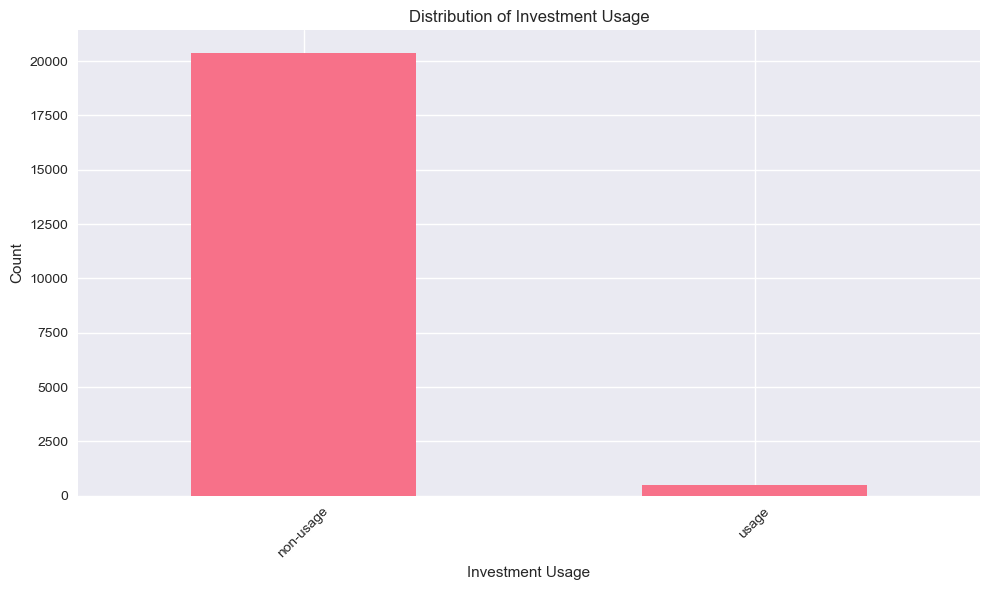

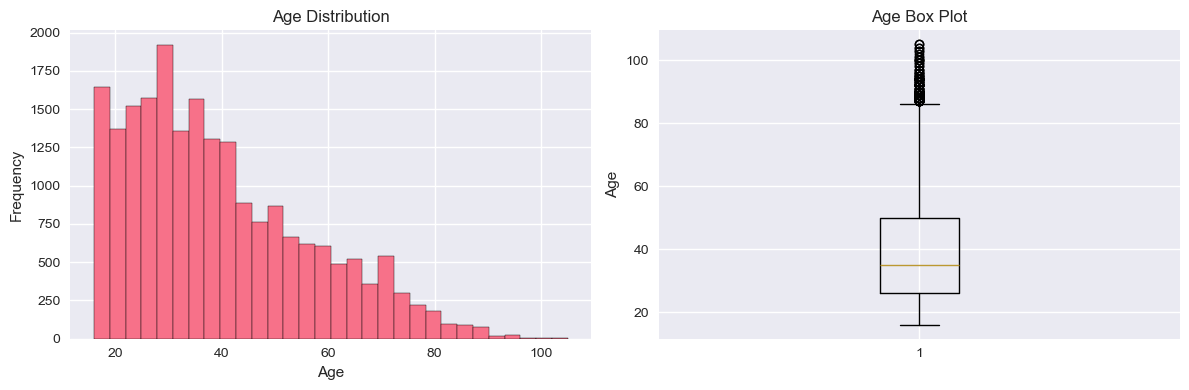

Age statistics:
count    20871.000000
mean        39.271429
std         17.210021
min         16.000000
25%         26.000000
50%         35.000000
75%         50.000000
max        105.000000
Name: age_of_respondent, dtype: float64


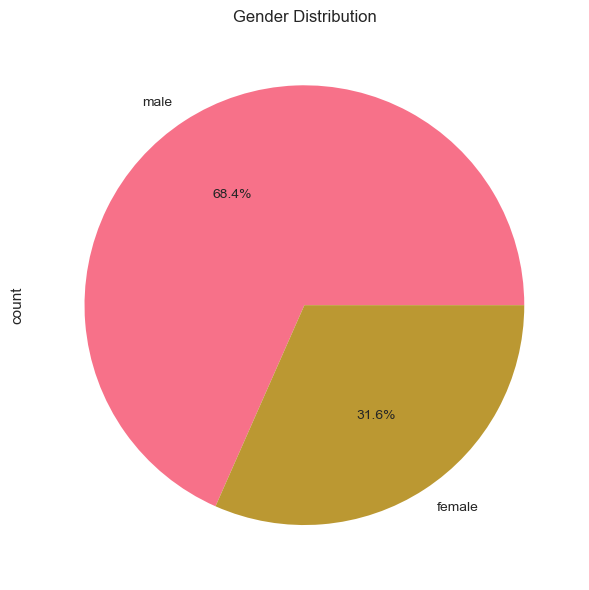

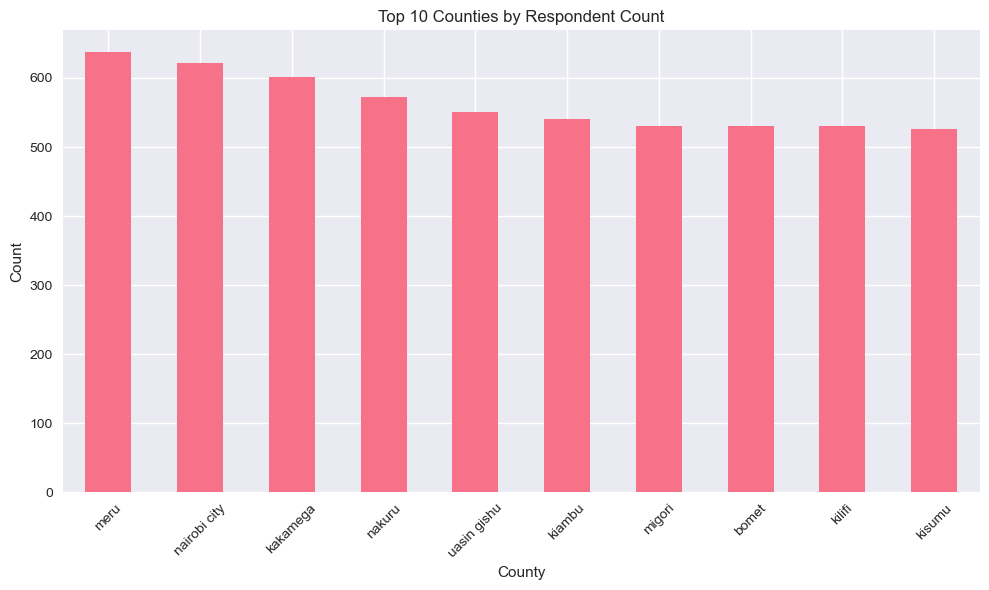

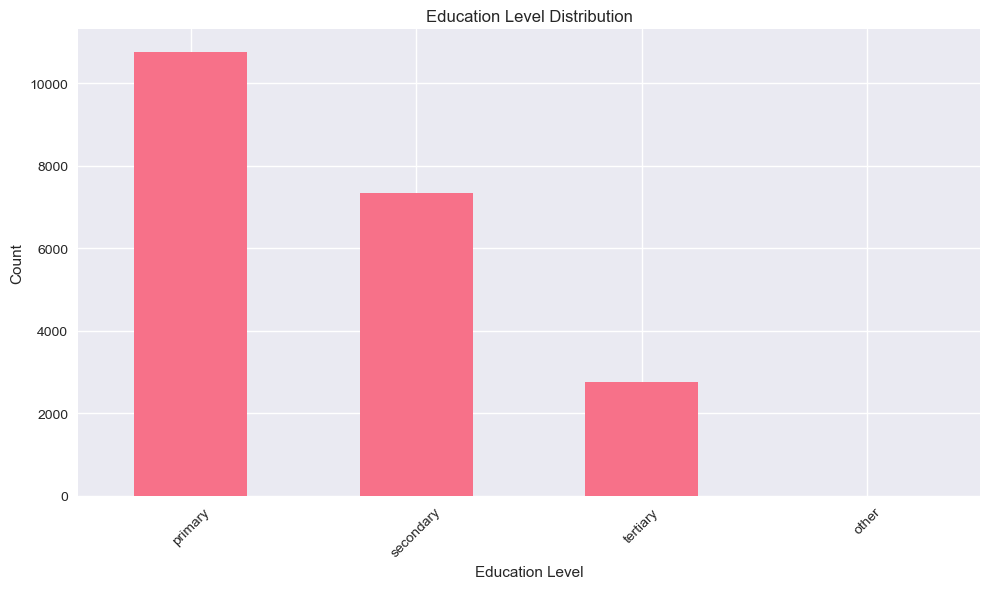

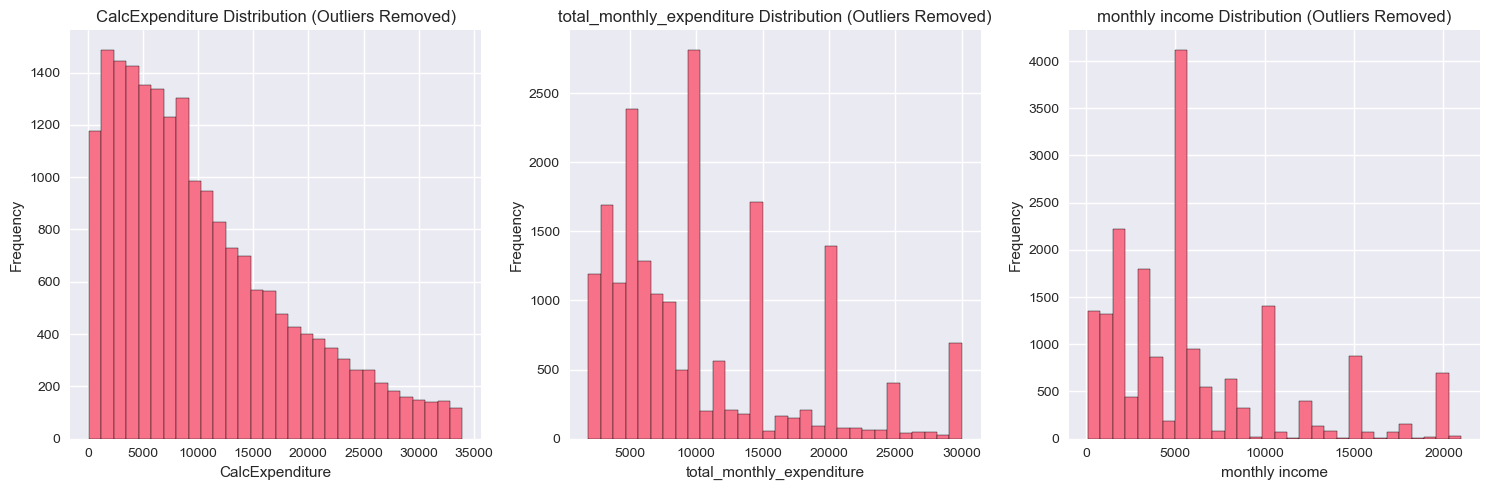


=== PRODUCT USAGE SUMMARY ===
               Pension_usage  Pension_Usage_without_NSSF  Mobile_bank_usage  \
Pension_usage                                                                 
non-usage              18966                       20541              15363   
usage                   1905                         330               5508   

               Non_microfinance_bank_usage  Microfinance_usage  Sacco_usage  \
Pension_usage                                                                 
non-usage                            20823               20692        18433   
usage                                   48                 179         2438   

               Digital_currencies_assets_usage  Investment_usage  \
Pension_usage                                                      
non-usage                                20807             20390   
usage                                       64               481   

               Informal_group_usage  Digital_credit_usage  ...

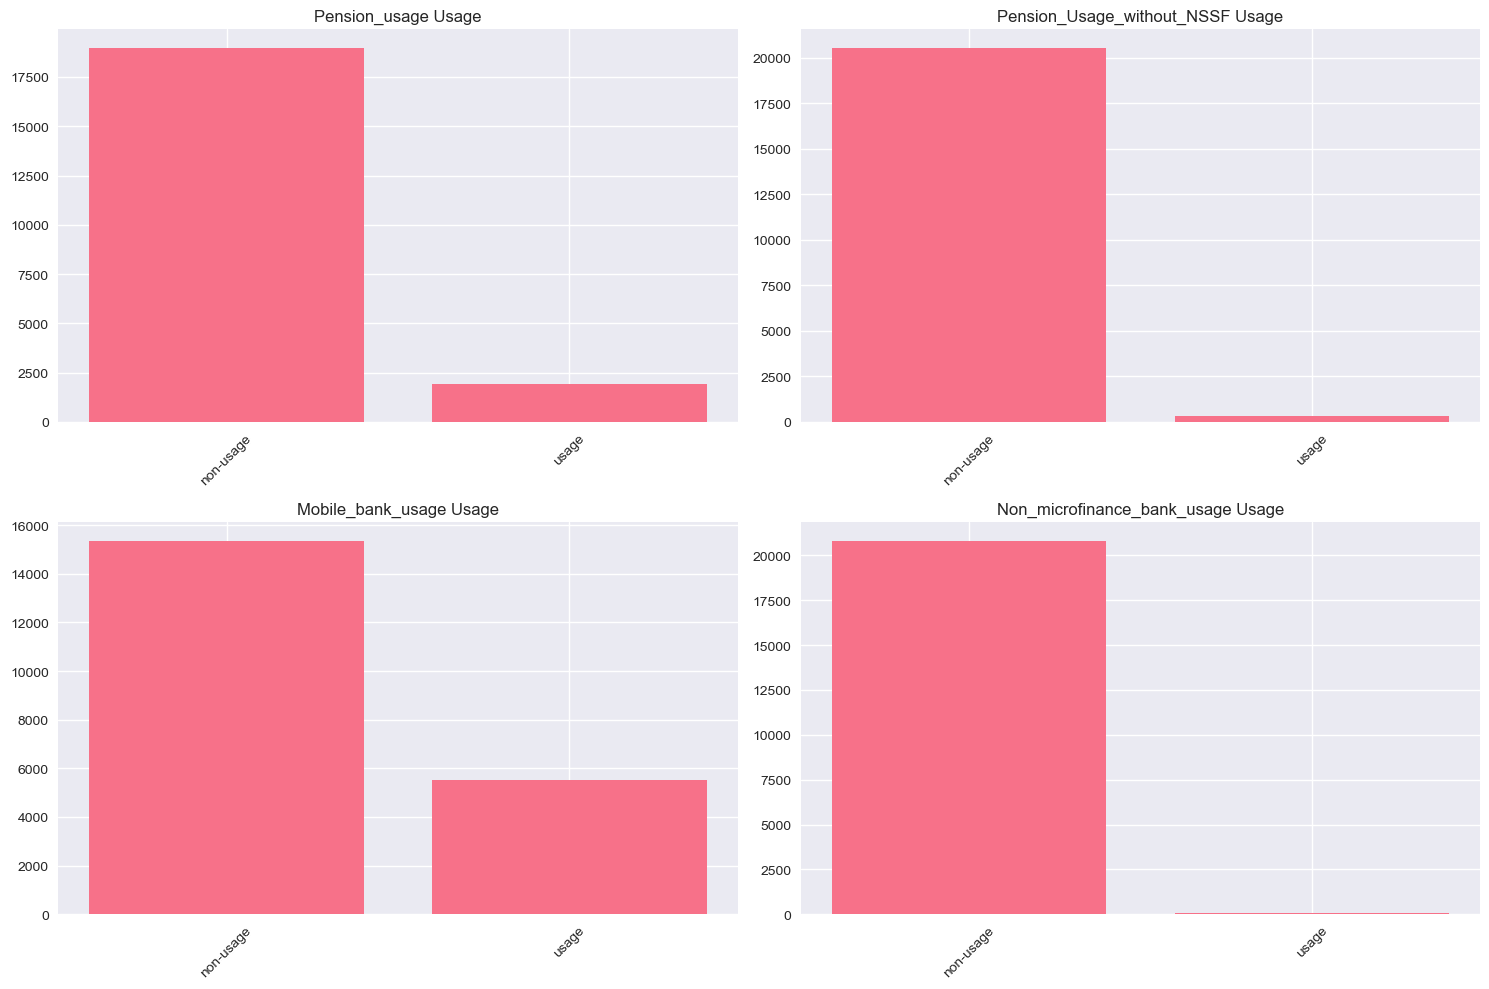

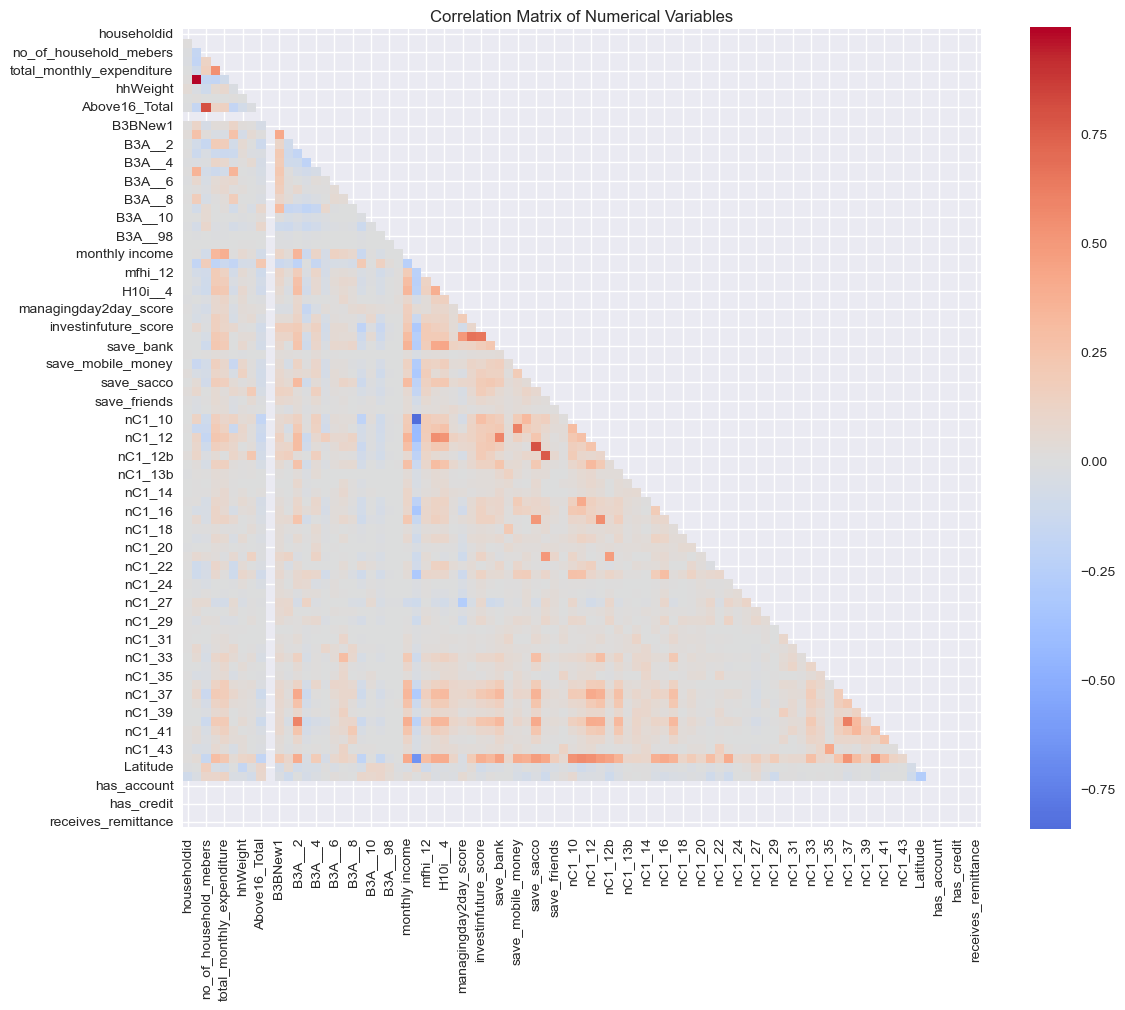


=== HIGH CORRELATION PAIRS (|r| > 0.7) ===
age_of_respondent <-> no_respodent_per_hh: 0.993
no_of_household_mebers <-> Above16_Total: 0.800
Access_fnl_1 <-> nC1_10: -0.843
save_sacco <-> nC1_12a: 0.797
save_chama <-> nC1_12b: 0.761

=== DATA QUALITY ASSESSMENT ===
Duplicate rows: 0
county: 47 unique values
area_type: 2 unique values
  Values: ['urban' 'rural']
gender: 2 unique values
  Values: ['male' 'female']
livelihoodcat: 6 unique values
  Values: ['dependent' 'other' 'casual worker' 'own business' 'agriculture'
 'employed']
Quintiles: 5 unique values
  Values: ['fourth' 'second' 'middle' 'highest' 'lowest']

Data Completeness by Column:
  householdid: 100.0%
  county: 100.0%
  area_type: 100.0%
  gender: 100.0%
  age_of_respondent: 100.0%
  no_of_household_mebers: 100.0%
  livelihoodcat: 100.0%
  Quintiles: 100.0%
  Education: 100.0%
  Marital: 100.0%

=== INVESTMENT USAGE BY DEMOGRAPHICS ===
Investment Usage by Age Group:
Investment_usage  non-usage  usage
age_group             

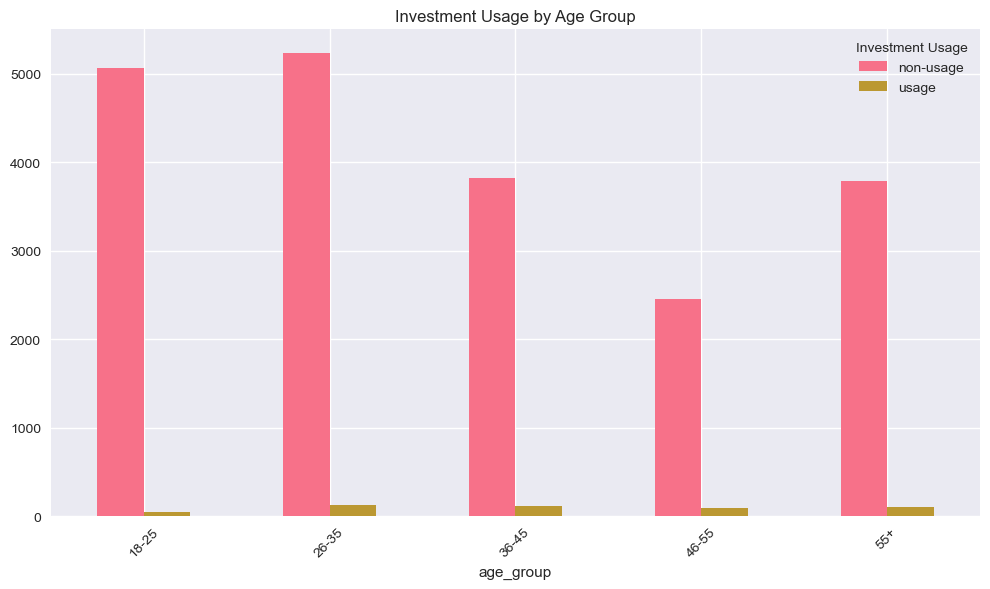


Investment Usage by Education Level:
Investment_usage  non-usage  usage
Education                         
other                     9      0
primary               10684     78
secondary              7183    162
tertiary               2514    241


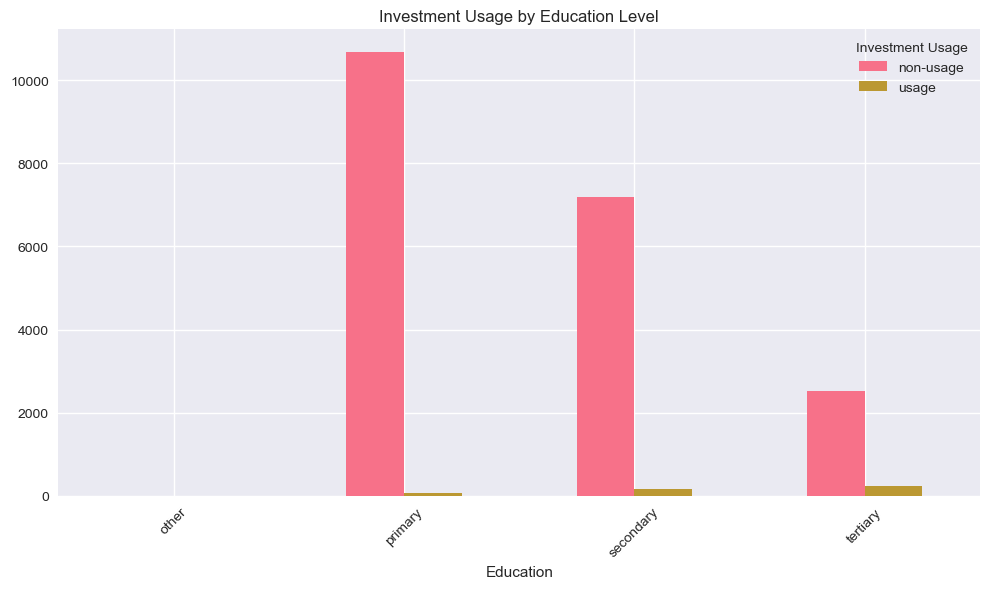


=== INITIAL INSIGHTS ===
1. Investment Usage Patterns:
   - Analyze relationship between demographics and investment usage
   - Urban vs rural investment behavior differences
   - Income level impact on investment choices

2. Product Cross-selling Opportunities:
   - Users with savings might be good candidates for investments
   - Mobile money users could be introduced to digital investments
   - Higher educated individuals show different usage patterns

3. Risk Profile Indicators:
   - Age and investment risk tolerance relationship
   - Education level and sophisticated product usage
   - Income stability and long-term investment products

=== DATA UNDERSTANDING SUMMARY ===
✓ Dataset contains 20,871 records and 393 features
✓ Mixed data types: numerical, categorical, and binary indicators
✓ Geographic coverage across multiple counties
✓ Comprehensive financial behavior tracking
✓ Investment usage can serve as target variable
✓ Multiple product usage variables for recommendation featu

In [2]:
# Phase 2: Data Understanding - Investment Recommendation System

# Helper function to safely plot data
def safe_plot(data, plot_type='bar', title='', xlabel='', ylabel='', **kwargs):
    """Safely plot data with error handling"""
    try:
        if isinstance(data, pd.Series):
            if len(data) == 0:
                print(f"Warning: No data to plot for {title}")
                return
            if data.isnull().all():
                print(f"Warning: All values are null for {title}")
                return
        
        plt.figure(figsize=kwargs.get('figsize', (10, 6)))
        
        if plot_type == 'bar':
            data.plot(kind='bar')
        elif plot_type == 'pie':
            data.plot(kind='pie', autopct='%1.1f%%')
        elif plot_type == 'hist':
            data.hist(bins=kwargs.get('bins', 30), edgecolor='black')
        
        plt.title(title)
        if xlabel:
            plt.xlabel(xlabel)
        if ylabel:
            plt.ylabel(ylabel)
        
        if plot_type == 'bar':
            plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error plotting {title}: {str(e)}")
        print("Continuing with next analysis...")

## 2.1 Initial Data Loading and Overview

# Load the dataset
df = pd.read_csv('final_refined.csv')
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

## 2.2 Dataset Structure Analysis

print("=== DATASET OVERVIEW ===")
print(f"Number of rows: {df.shape[0]:,}")
print(f"Number of columns: {df.shape[1]:,}")
print(f"\nData types:")
print(df.dtypes.value_counts())

# Display first few rows
print("\n=== SAMPLE DATA ===")
print(df.head())

# Basic info about the dataset
print("\n=== DATASET INFO ===")
df.info(memory_usage='deep')

## 2.3 Column Analysis and Categorization

# Get actual columns from the dataframe
actual_columns = df.columns.tolist()

# Categorize columns based on what's actually in the dataset
demographic_cols = [col for col in actual_columns if any(x in col.lower() for x in 
                   ['household', 'county', 'area', 'gender', 'age', 'education', 'marital'])]

financial_behavior_cols = [col for col in actual_columns if any(x in col.lower() for x in 
                          ['expenditure', 'income', 'savings', 'loan', 'investment'])]

product_usage_cols = [col for col in actual_columns if any(x in col.lower() for x in 
                     ['usage', 'bank', 'mobile', 'sacco', 'insurance', 'pension'])]

investment_cols = [col for col in actual_columns if 'investment' in col.lower()]

print("=== COLUMN CATEGORIZATION ===")
print(f"Demographic columns ({len(demographic_cols)}): {demographic_cols}")
print(f"Financial behavior columns ({len(financial_behavior_cols)}): {financial_behavior_cols}")
print(f"Product usage columns ({len(product_usage_cols)}): {product_usage_cols}")
print(f"Investment-specific columns ({len(investment_cols)}): {investment_cols}")

## 2.4 Missing Values Analysis

missing_analysis = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
}).sort_values('Missing_Percentage', ascending=False)

print("\n=== MISSING VALUES ANALYSIS ===")
print(missing_analysis.head(20))

# Visualize missing values - only if there are missing values
if missing_analysis['Missing_Percentage'].max() > 0:
    plt.figure(figsize=(12, 8))
    missing_cols = missing_analysis[missing_analysis['Missing_Percentage'] > 0].head(20)
    if len(missing_cols) > 0:
        plt.barh(missing_cols['Column'], missing_cols['Missing_Percentage'])
        plt.xlabel('Missing Percentage (%)')
        plt.title('Top 20 Columns with Missing Values')
        plt.tight_layout()
        plt.show()
else:
    print("No missing values found in the dataset")

## 2.5 Target Variable Analysis (Investment Usage)

investment_col = None
for col in df.columns:
    if 'investment' in col.lower() and 'usage' in col.lower():
        investment_col = col
        break

if investment_col:
    print(f"\n=== INVESTMENT USAGE DISTRIBUTION ({investment_col}) ===")
    
    # Clean the data first
    investment_data = df[investment_col].dropna()
    
    if len(investment_data) > 0:
        investment_dist = investment_data.value_counts()
        print(investment_dist)
        
        # Safe plotting with validation
        if len(investment_dist) > 0:
            safe_plot(investment_dist, 'bar', 
                     'Distribution of Investment Usage', 
                     'Investment Usage', 'Count')
        else:
            print("No valid investment usage data to plot")
    else:
        print("No investment usage data available")
else:
    print("Investment usage column not found in dataset")

## 2.6 Demographic Analysis

# Age distribution
age_col = None
for col in df.columns:
    if 'age' in col.lower():
        age_col = col
        break

if age_col and age_col in df.columns:
    age_data = df[age_col].dropna()
    
    if len(age_data) > 0:
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        age_data.hist(bins=30, edgecolor='black')
        plt.title('Age Distribution')
        plt.xlabel('Age')
        plt.ylabel('Frequency')
        
        plt.subplot(1, 2, 2)
        plt.boxplot(age_data)
        plt.title('Age Box Plot')
        plt.ylabel('Age')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Age statistics:")
        print(age_data.describe())

# Gender distribution
gender_col = None
for col in df.columns:
    if 'gender' in col.lower():
        gender_col = col
        break

if gender_col and gender_col in df.columns:
    gender_data = df[gender_col].dropna()
    if len(gender_data) > 0:
        gender_dist = gender_data.value_counts()
        if len(gender_dist) > 0:
            safe_plot(gender_dist, 'pie', 'Gender Distribution')

# Geographic distribution
county_col = None
for col in df.columns:
    if 'county' in col.lower():
        county_col = col
        break

if county_col and county_col in df.columns:
    county_data = df[county_col].dropna()
    if len(county_data) > 0:
        county_dist = county_data.value_counts().head(10)
        if len(county_dist) > 0:
            safe_plot(county_dist, 'bar', 
                     'Top 10 Counties by Respondent Count', 
                     'County', 'Count')

# Education distribution
education_col = None
for col in df.columns:
    if 'education' in col.lower():
        education_col = col
        break

if education_col and education_col in df.columns:
    education_data = df[education_col].dropna()
    if len(education_data) > 0:
        education_dist = education_data.value_counts()
        if len(education_dist) > 0:
            safe_plot(education_dist, 'bar', 'Education Level Distribution', 
                     'Education Level', 'Count')

## 2.7 Financial Variables Analysis

# Find financial columns
financial_vars = []
for col in df.columns:
    if any(x in col.lower() for x in ['expenditure', 'income', 'salary']):
        financial_vars.append(col)

if financial_vars:
    fig, axes = plt.subplots(1, len(financial_vars), figsize=(15, 5))
    if len(financial_vars) == 1:
        axes = [axes]
    
    for i, var in enumerate(financial_vars):
        try:
            # Clean data and remove outliers for visualization
            clean_data = df[var].dropna()
            if len(clean_data) > 0:
                Q1 = clean_data.quantile(0.25)
                Q3 = clean_data.quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                filtered_data = clean_data[(clean_data >= lower_bound) & (clean_data <= upper_bound)]
                
                if len(filtered_data) > 0:
                    axes[i].hist(filtered_data, bins=30, edgecolor='black')
                    axes[i].set_title(f'{var} Distribution (Outliers Removed)')
                    axes[i].set_xlabel(var)
                    axes[i].set_ylabel('Frequency')
        except Exception as e:
            print(f"Error plotting {var}: {str(e)}")
    
    plt.tight_layout()
    plt.show()

## 2.8 Product Usage Patterns

# Find usage columns
usage_products = []
for col in df.columns:
    if 'usage' in col.lower():
        usage_products.append(col)

if usage_products:
    usage_summary = pd.DataFrame()
    valid_products = []
    
    for product in usage_products:
        try:
            usage_data = df[product].dropna()
            if len(usage_data) > 0:
                usage_counts = usage_data.value_counts()
                if len(usage_counts) > 0:
                    usage_summary[product] = usage_counts
                    valid_products.append(product)
        except Exception as e:
            print(f"Error processing {product}: {str(e)}")
    
    if len(valid_products) > 0:
        print("\n=== PRODUCT USAGE SUMMARY ===")
        print(usage_summary)
        
        # Visualize usage patterns
        n_products = min(4, len(valid_products))  # Max 4 subplots
        if n_products > 0:
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            axes = axes.ravel()
            
            for i, product in enumerate(valid_products[:n_products]):
                try:
                    product_data = df[product].dropna().value_counts()
                    if len(product_data) > 0:
                        axes[i].bar(range(len(product_data)), product_data.values)
                        axes[i].set_title(f'{product} Usage')
                        axes[i].set_xticks(range(len(product_data)))
                        axes[i].set_xticklabels(product_data.index, rotation=45)
                except Exception as e:
                    print(f"Error plotting {product}: {str(e)}")
            
            plt.tight_layout()
            plt.show()

## 2.9 Correlation Analysis

# Select numerical columns for correlation analysis
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if len(numerical_cols) > 1:
    try:
        # Remove columns with all NaN values
        valid_numerical_cols = []
        for col in numerical_cols:
            if not df[col].isnull().all():
                valid_numerical_cols.append(col)
        
        if len(valid_numerical_cols) > 1:
            correlation_matrix = df[valid_numerical_cols].corr()
            
            # Plot correlation heatmap
            plt.figure(figsize=(12, 10))
            mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
            sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', 
                       center=0, fmt='.2f', square=True, annot=True)
            plt.title('Correlation Matrix of Numerical Variables')
            plt.tight_layout()
            plt.show()
            
            # Find highly correlated variables
            high_corr_pairs = []
            for i in range(len(correlation_matrix.columns)):
                for j in range(i+1, len(correlation_matrix.columns)):
                    corr_value = correlation_matrix.iloc[i, j]
                    if not np.isnan(corr_value) and abs(corr_value) > 0.7:  # High correlation threshold
                        high_corr_pairs.append((correlation_matrix.columns[i], 
                                              correlation_matrix.columns[j], 
                                              corr_value))
            
            if high_corr_pairs:
                print("\n=== HIGH CORRELATION PAIRS (|r| > 0.7) ===")
                for pair in high_corr_pairs[:10]:  # Show top 10
                    print(f"{pair[0]} <-> {pair[1]}: {pair[2]:.3f}")
            else:
                print("\n=== No highly correlated pairs found (|r| > 0.7) ===")
                
    except Exception as e:
        print(f"Error in correlation analysis: {str(e)}")

## 2.10 Data Quality Assessment

print("\n=== DATA QUALITY ASSESSMENT ===")

# Check for duplicates
duplicate_count = df.duplicated().sum()
print(f"Duplicate rows: {duplicate_count}")

# Check for inconsistencies in categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols[:5]:  # Check first 5 categorical columns
    try:
        unique_values = df[col].nunique()
        print(f"{col}: {unique_values} unique values")
        if unique_values < 20:  # Show values if not too many
            unique_vals = df[col].dropna().unique()
            print(f"  Values: {unique_vals}")
    except Exception as e:
        print(f"Error analyzing {col}: {str(e)}")

# Data completeness
completeness = (df.count() / len(df)) * 100
print(f"\nData Completeness by Column:")
for col in completeness.index[:10]:  # Show first 10
    print(f"  {col}: {completeness[col]:.1f}%")

## 2.11 Investment Usage Analysis by Demographics

if investment_col:
    print(f"\n=== INVESTMENT USAGE BY DEMOGRAPHICS ===")
    
    # By Age Groups
    if age_col:
        df['age_group'] = pd.cut(df[age_col], bins=[0, 25, 35, 45, 55, 100], 
                                labels=['18-25', '26-35', '36-45', '46-55', '55+'])
        age_investment = pd.crosstab(df['age_group'], df[investment_col])
        if len(age_investment) > 0:
            print("Investment Usage by Age Group:")
            print(age_investment)
            
            # Plot
            age_investment.plot(kind='bar', figsize=(10, 6))
            plt.title('Investment Usage by Age Group')
            plt.xticks(rotation=45)
            plt.legend(title='Investment Usage')
            plt.tight_layout()
            plt.show()
    
    # By Education Level
    if education_col:
        education_investment = pd.crosstab(df[education_col], df[investment_col])
        if len(education_investment) > 0:
            print("\nInvestment Usage by Education Level:")
            print(education_investment)
            
            # Plot
            education_investment.plot(kind='bar', figsize=(10, 6))
            plt.title('Investment Usage by Education Level')
            plt.xticks(rotation=45)
            plt.legend(title='Investment Usage')
            plt.tight_layout()
            plt.show()

## 2.12 Initial Insights and Hypotheses

print("\n=== INITIAL INSIGHTS ===")
print("1. Investment Usage Patterns:")
print("   - Analyze relationship between demographics and investment usage")
print("   - Urban vs rural investment behavior differences")
print("   - Income level impact on investment choices")

print("\n2. Product Cross-selling Opportunities:")
print("   - Users with savings might be good candidates for investments")
print("   - Mobile money users could be introduced to digital investments")
print("   - Higher educated individuals show different usage patterns")

print("\n3. Risk Profile Indicators:")
print("   - Age and investment risk tolerance relationship")
print("   - Education level and sophisticated product usage")
print("   - Income stability and long-term investment products")

## 2.13 Data Understanding Summary

print("\n=== DATA UNDERSTANDING SUMMARY ===")
print(f"✓ Dataset contains {df.shape[0]:,} records and {df.shape[1]:,} features")
print(f"✓ Mixed data types: numerical, categorical, and binary indicators")
print(f"✓ Geographic coverage across multiple counties")
print(f"✓ Comprehensive financial behavior tracking")
print(f"✓ Investment usage can serve as target variable")
print(f"✓ Multiple product usage variables for recommendation features")

# Save processed understanding for next phase
try:
    df.to_csv('data_understanding_output.csv', index=False)
    print(f"✓ Data understanding output saved to 'data_understanding_output.csv'")
except:
    print("Warning: Could not save data understanding output")

print("\nNext Phase: Data Preparation")
print("- Clean and preprocess the data")
print("- Create meaningful features for recommendation system")
print("- Handle missing values and outliers")
print("- Prepare data for modeling")

# Create summary statistics
summary_stats = {
    'total_records': len(df),
    'total_features': len(df.columns),
    'missing_values': df.isnull().sum().sum(),
    'duplicate_records': duplicate_count,
    'numerical_features': len(df.select_dtypes(include=[np.number]).columns),
    'categorical_features': len(df.select_dtypes(include=['object']).columns),
    'investment_usage_rate': df[investment_col].value_counts().get('Yes', 0) / len(df) * 100 if investment_col else 0
}

print(f"\n=== FINAL STATISTICS ===")
for key, value in summary_stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value}")

Original dataset shape: (20871, 392)
Renamed 13 columns for better readability

=== MISSING VALUES SUMMARY ===
No missing values found
Missing values after treatment: 0
Memory usage before optimization: 400.75586128234863 MB
Memory usage after optimization: 11.597643852233887 MB
Dataset shape after feature engineering: (20871, 401)

=== OUTLIER TREATMENT SUMMARY ===
                       column  outliers
0             CalcExpenditure       837
1         monthly_expenditure      1371
2         no_respodent_per_hh       150
3                    hhWeight      1176
4   Informal_group_membership       753
5               Above16_Total      1276
6                     B3BNew1       155
10             monthly income      2016
11               Access_fnl_1      3875
19                   prodsum1       222
20                   Latitude      2735
21                  Longitude        90
Dataset shape after encoding: (20871, 907)
Scaled 90 numerical features

=== INVESTMENT PRODUCT CATEGORIES ===


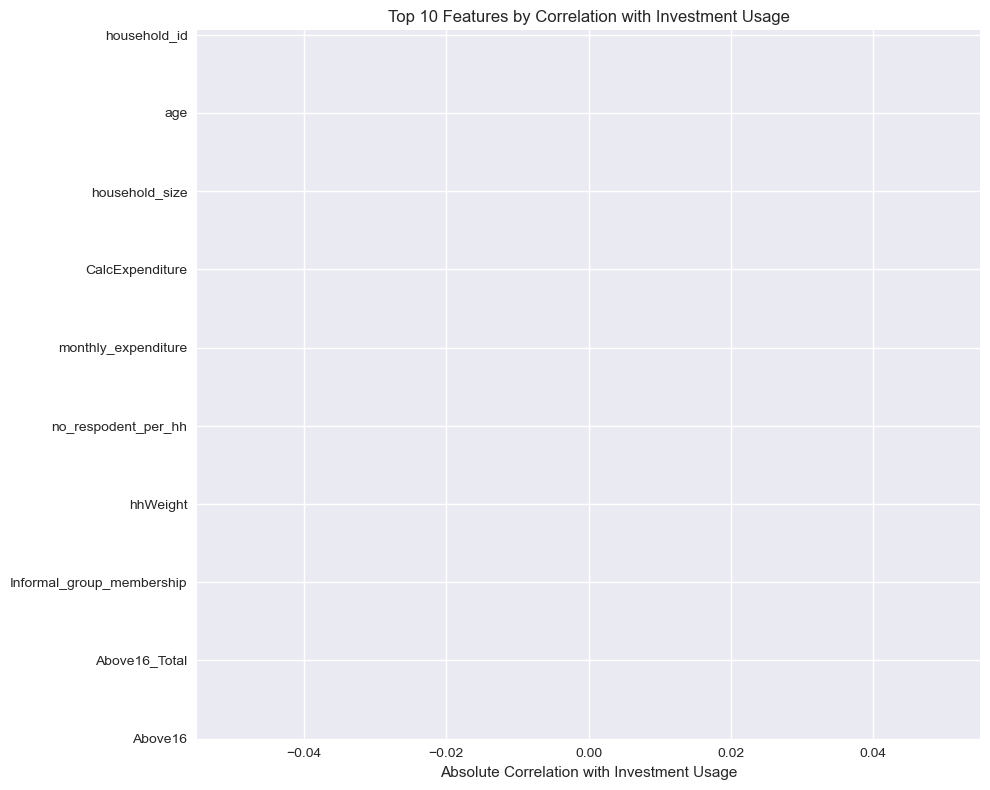


DATA PREPARATION SUMMARY
✓ Original dataset shape: (20871, 392)
✓ Final dataset shape: (20871, 908)
✓ Features created: 516
✓ Missing values handled: Yes
✓ Outliers treated: Yes
✓ Categorical encoding: Completed
✓ Feature scaling: Applied
✓ User segmentation: Created
✓ Train-test split: Prepared
✓ Data quality: Validated

Key Features for Recommendation System:
  - digital_sophistication
  - product_diversification
  - risk_tolerance
  - user_segment
  - investment_readiness_score

Dataset ready for modeling:
- Training samples: 16696
- Test samples: 4175
- Features: 881
- Target variable: investment_usage (binary)
- User segments: 4
- Investment products mapped: 19

Next Phase: Modeling
- Implement machine learning models
- Build recommendation algorithms
- Create hybrid recommendation system
- Add deep learning components


In [3]:
# Phase 3: Data Preparation - Investment Recommendation System

## 3.1 Load and Initial Setup

# Load the raw data
try:
    df = pd.read_csv('final_refined.csv')
    print(f"Original dataset shape: {df.shape}")
except FileNotFoundError:
    df = pd.read_csv('data_understanding_output.csv')
    print(f"Loaded data from understanding phase: {df.shape}")
    

# Create a backup of original data
df_original = df.copy()

## 3.2 Column Renaming for Readability

# Define column mapping for better readability
column_mapping = {
    'householdid': 'household_id',
    'area_type': 'location_type',
    'age_of_respondent': 'age',
    'no_of_household_mebers': 'household_size',
    'total_monthly_expenditure': 'monthly_expenditure',
    'monthly_income': 'monthly_income',
    'digital_loans': 'digital_loans_usage',
    'Investment_usage': 'investment_usage',
    'Mobile_bank_usage': 'mobile_banking',
    'Savings_usage': 'savings_usage',
    'Loan_usage': 'loan_usage',
    'Education': 'education_level',
    'Marital': 'marital_status',
    'NHIF': 'nhif_usage',
    'Sacco_usage': 'sacco_usage'
}

# Apply column renaming (only for columns that exist)
existing_mappings = {k: v for k, v in column_mapping.items() if k in df.columns}
df.rename(columns=existing_mappings, inplace=True)
print(f"Renamed {len(existing_mappings)} columns for better readability")

## 3.3 Missing Value Treatment

# Analyze missing values
missing_summary = pd.DataFrame({
    'column': df.columns,
    'missing_count': df.isnull().sum(),
    'missing_percent': (df.isnull().sum() / len(df)) * 100,
    'dtype': df.dtypes
})
missing_summary = missing_summary[missing_summary['missing_count'] > 0].sort_values('missing_percent', ascending=False)

print("\n=== MISSING VALUES SUMMARY ===")
if len(missing_summary) > 0:
    print(missing_summary.head(10))
else:
    print("No missing values found")

# Define imputation strategies
def handle_missing_values(df):
    """Handle missing values with appropriate strategies"""
    
    # Categorical variables - fill with mode or 'unknown'
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            mode_value = df[col].mode()
            if len(mode_value) > 0:
                df[col].fillna(mode_value[0], inplace=True)
            else:
                df[col].fillna('unknown', inplace=True)
    
    # Numerical variables - use median for skewed data, mean for normal
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        if df[col].isnull().sum() > 0:
            # Check skewness
            skewness = df[col].skew()
            if abs(skewness) > 1:  # Highly skewed
                df[col].fillna(df[col].median(), inplace=True)
            else:
                df[col].fillna(df[col].mean(), inplace=True)
    
    return df

df = handle_missing_values(df)
print(f"Missing values after treatment: {df.isnull().sum().sum()}")

## 3.4 Data Type Optimization

def optimize_dtypes(df):
    """Optimize data types to reduce memory usage"""
    
    # Convert object columns with limited unique values to category
    for col in df.select_dtypes(include=['object']).columns:
        unique_ratio = df[col].nunique() / len(df)
        if unique_ratio < 0.5:  # Less than 50% unique values
            df[col] = df[col].astype('category')
    
    # Convert integer columns to smaller types where possible
    for col in df.select_dtypes(include=['int64']).columns:
        col_min = df[col].min()
        col_max = df[col].max()
        
        if pd.isna(col_min) or pd.isna(col_max):
            continue
            
        if col_min >= -128 and col_max <= 127:
            df[col] = df[col].astype('int8')
        elif col_min >= -32768 and col_max <= 32767:
            df[col] = df[col].astype('int16')
        elif col_min >= -2147483648 and col_max <= 2147483647:
            df[col] = df[col].astype('int32')
    
    # Convert float columns to float32 where possible
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    
    return df

print("Memory usage before optimization:", df.memory_usage(deep=True).sum() / 1024**2, "MB")
df = optimize_dtypes(df)
print("Memory usage after optimization:", df.memory_usage(deep=True).sum() / 1024**2, "MB")

## 3.5 Feature Engineering

def safe_count_usage(row, columns):
    """Safely count usage values in a row"""
    count = 0
    for col in columns:
        if col not in row.index:
            continue
        value = row[col]
        if pd.isna(value):
            continue
        elif isinstance(value, str):
            if value.lower() in ['yes', 'usage', '1']:
                count += 1
        elif isinstance(value, (int, float)):
            if value == 1:  # Assuming 1 means usage
                count += 1
    return count

def create_features(df):
    """Create meaningful features for investment recommendation"""
    
    # Age groups
    if 'age' in df.columns:
        df['age_group'] = pd.cut(df['age'], 
                                bins=[0, 25, 35, 45, 55, 100], 
                                labels=['18-25', '26-35', '36-45', '46-55', '55+'])
    
    # Income-to-expenditure ratio
    if 'monthly_income' in df.columns and 'monthly_expenditure' in df.columns:
        # Handle division by zero and negative values
        expenditure_safe = df['monthly_expenditure'].clip(lower=1)
        df['income_expenditure_ratio'] = df['monthly_income'] / expenditure_safe
        df['savings_potential'] = df['monthly_income'] - df['monthly_expenditure']
        
        # Handle division by zero for savings rate
        income_safe = df['monthly_income'].clip(lower=1)
        df['savings_rate'] = df['savings_potential'] / income_safe
        
        # Cap extreme values
        df['income_expenditure_ratio'] = df['income_expenditure_ratio'].clip(0, 10)
        df['savings_rate'] = df['savings_rate'].clip(-1, 1)
    
    # Financial sophistication score
    digital_services = ['mobile_banking', 'digital_loans_usage', 'digital_credit']
    existing_digital = [col for col in digital_services if col in df.columns]
    
    if existing_digital:
        df['digital_services_count'] = df[existing_digital].apply(
            lambda row: safe_count_usage(row, existing_digital), axis=1
        )
        df['digital_sophistication'] = df['digital_services_count'] / len(existing_digital)
    else:
        # Create default values if no digital services columns exist
        df['digital_services_count'] = 0
        df['digital_sophistication'] = 0
    
    # Product diversification score
    financial_products = ['savings_usage', 'loan_usage', 'investment_usage']
    existing_products = [col for col in financial_products if col in df.columns]
    
    if existing_products:
        df['products_used_count'] = df[existing_products].apply(
            lambda row: safe_count_usage(row, existing_products), axis=1
        )
        df['product_diversification'] = df['products_used_count'] / len(existing_products)
    else:
        # Create default values
        df['products_used_count'] = 0
        df['product_diversification'] = 0
    
    # Risk profile based on age and income
    if 'age' in df.columns:
        df['risk_tolerance'] = np.where(df['age'] < 30, 'high',
                                       np.where(df['age'] < 50, 'medium', 'low'))
    else:
        df['risk_tolerance'] = 'medium'
    
    # Urban/rural investment readiness
    if 'location_type' in df.columns:
        df['location_investment_readiness'] = np.where(
            df['location_type'].astype(str).str.lower() == 'urban', 1, 0
        )
    else:
        df['location_investment_readiness'] = 0
    
    # Education level encoding
    if 'education_level' in df.columns:
        education_mapping = {'Primary': 1, 'Secondary': 2, 'Tertiary': 3}
        df['education_score'] = df['education_level'].astype(str).map(education_mapping).fillna(1)
    else:
        df['education_score'] = 2  # Default to secondary
    
    # Household financial pressure
    if 'household_size' in df.columns and 'monthly_income' in df.columns:
        df['income_per_person'] = df['monthly_income'] / df['household_size'].clip(lower=1)
        df['financial_pressure'] = np.where(df['income_per_person'] < 10000, 'high',
                                           np.where(df['income_per_person'] < 25000, 'medium', 'low'))
    
    # Investment readiness score (composite)
    readiness_factors = []
    if 'digital_sophistication' in df.columns:
        readiness_factors.append(df['digital_sophistication'])
    if 'education_score' in df.columns:
        readiness_factors.append(df['education_score'] / 3)  # Normalize to 0-1
    if 'location_investment_readiness' in df.columns:
        readiness_factors.append(df['location_investment_readiness'])
    if 'savings_rate' in df.columns:
        readiness_factors.append((df['savings_rate'] + 1) / 2)  # Normalize to 0-1
    
    if readiness_factors:
        df['investment_readiness_score'] = np.mean(readiness_factors, axis=0)
    else:
        df['investment_readiness_score'] = 0.5
    
    return df

df = create_features(df)
print(f"Dataset shape after feature engineering: {df.shape}")

## 3.6 Outlier Detection and Treatment

def handle_outliers(df, method='iqr'):
    """Handle outliers in numerical columns"""
    
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    outlier_summary = []
    
    exclude_cols = ['household_id', 'age', 'household_size']  # Skip these columns
    
    for col in numerical_cols:
        if col not in exclude_cols:
            try:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                
                if IQR == 0:  # Skip if no variance
                    continue
                
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                outliers_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
                outlier_summary.append({'column': col, 'outliers': outliers_count})
                
                # Cap outliers instead of removing them
                df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
                df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
                
            except Exception as e:
                print(f"Error handling outliers in {col}: {str(e)}")
                continue
    
    outlier_df = pd.DataFrame(outlier_summary)
    print("\n=== OUTLIER TREATMENT SUMMARY ===")
    if len(outlier_df) > 0:
        outliers_found = outlier_df[outlier_df['outliers'] > 0]
        if len(outliers_found) > 0:
            print(outliers_found)
        else:
            print("No significant outliers found")
    else:
        print("No outlier treatment performed")
    
    return df

df = handle_outliers(df)

## 3.7 Encoding Categorical Variables

def encode_categorical_variables(df):
    """Encode categorical variables for machine learning"""
    
    # Separate categorical columns (both object and category types)
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Remove already encoded columns and ID columns
    categorical_cols = [col for col in categorical_cols 
                       if not col.endswith('_encoded') and 'id' not in col.lower()]
    
    # Binary encoding for binary categorical variables
    binary_cols = []
    for col in categorical_cols:
        # Convert to string to handle category types properly
        unique_vals = df[col].astype(str).dropna().unique()
        if len(unique_vals) == 2:
            binary_cols.append(col)
            # Encode as 0/1 (Yes=1, No=0)
            df[f'{col}_encoded'] = (df[col].astype(str).str.lower().isin(['yes', '1', 'true'])).astype(int)
    
    # Label encoding for ordinal variables
    ordinal_mapping = {
        'education_level': {'Primary': 1, 'Secondary': 2, 'Tertiary': 3},
        'risk_tolerance': {'low': 1, 'medium': 2, 'high': 3},
        'financial_pressure': {'low': 1, 'medium': 2, 'high': 3}
    }
    
    for col, mapping in ordinal_mapping.items():
        if col in df.columns:
            # Map values and handle NaN
            mapped_values = df[col].astype(str).map(mapping)
            df[f'{col}_encoded'] = mapped_values.fillna(0).astype(int)
    
    # One-hot encoding for nominal variables with few categories
    nominal_cols = [col for col in categorical_cols 
                   if col not in binary_cols 
                   and col not in ordinal_mapping.keys()
                   and df[col].nunique() <= 10]
    
    if nominal_cols:
        # Convert categorical columns to string before one-hot encoding
        for col in nominal_cols:
            if df[col].dtype.name == 'category':
                df[col] = df[col].astype(str)
        
        df_encoded = pd.get_dummies(df, columns=nominal_cols, prefix=nominal_cols, dummy_na=False)
        return df_encoded
    
    return df

df = encode_categorical_variables(df)
print(f"Dataset shape after encoding: {df.shape}")

## 3.8 Feature Scaling and Normalization

def scale_features(df):
    """Scale numerical features for machine learning"""
    
    # Identify numerical columns that need scaling
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Exclude ID columns, encoded columns, and counts
    exclude_patterns = ['id', '_encoded', '_count', 'household_size']
    cols_to_scale = []
    
    for col in numerical_cols:
        should_exclude = any(pattern in col.lower() for pattern in exclude_patterns)
        if not should_exclude:
            cols_to_scale.append(col)
    
    # Apply StandardScaler
    scaler = StandardScaler()
    df_scaled = df.copy()
    
    if cols_to_scale:
        try:
            # Handle any remaining NaN values
            df_scaled[cols_to_scale] = df_scaled[cols_to_scale].fillna(0)
            df_scaled[cols_to_scale] = scaler.fit_transform(df_scaled[cols_to_scale])
            
            # Save scaler for later use
            joblib.dump(scaler, 'feature_scaler.pkl')
            print(f"Scaled {len(cols_to_scale)} numerical features")
        except Exception as e:
            print(f"Error in feature scaling: {str(e)}")
            return df, None
    
    return df_scaled, scaler

df_scaled, scaler = scale_features(df)

## 3.9 Investment Product Mapping

def create_investment_product_mapping():
    """Create mapping of investment products to categories"""
    
    product_mapping = {
        'low_risk': {
            'products': ['savings_account', 'fixed_deposit', 'government_bonds', 'money_market_funds', 'treasury_bills'],
            'description': 'Conservative investments with guaranteed returns',
            'risk_level': 1,
            'expected_return': 'low',
            'liquidity': 'high',
            'min_investment': 1000,
            'target_segment': ['retiree', 'conservative']
        },
        'medium_risk': {
            'products': ['balanced_funds', 'unit_trusts', 'reits', 'pension_schemes', 'cooperative_investments'],
            'description': 'Moderate risk investments with balanced returns',
            'risk_level': 2,
            'expected_return': 'medium',
            'liquidity': 'medium',
            'min_investment': 2000,
            'target_segment': ['family_oriented', 'pre_retirement']
        },
        'high_risk': {
            'products': ['equity_funds', 'nse_stocks', 'commodities', 'forex_trading', 'business_investment'],
            'description': 'High risk investments with potential high returns',
            'risk_level': 3,
            'expected_return': 'high',
            'liquidity': 'low',
            'min_investment': 5000,
            'target_segment': ['young_professional', 'aggressive']
        },
        'alternative': {
            'products': ['real_estate', 'agricultural_investment', 'education_savings', 'digital_assets'],
            'description': 'Alternative investments for portfolio diversification',
            'risk_level': 2,
            'expected_return': 'medium_high',
            'liquidity': 'very_low',
            'min_investment': 10000,
            'target_segment': ['diversified', 'long_term']
        }
    }
    
    return product_mapping

investment_products = create_investment_product_mapping()
print("\n=== INVESTMENT PRODUCT CATEGORIES ===")
for category, details in investment_products.items():
    print(f"{category.upper()}: {len(details['products'])} products")

## 3.10 User Segmentation Features

def create_user_segments(df):
    """Create user segments for targeted recommendations"""
    
    # Initialize segment
    df['user_segment'] = 'unknown'
    
    # Define segmentation logic based on available columns
    age_col = 'age' if 'age' in df.columns else None
    location_col = 'location_type' if 'location_type' in df.columns else None
    education_col = 'education_level' if 'education_level' in df.columns else None
    income_col = 'monthly_income' if 'monthly_income' in df.columns else None
    
    # Young Urban Professional
    if age_col and location_col and income_col:
        location_vals = df[location_col].astype(str).str.lower()
        young_urban_prof = (
            (df[age_col] < 35) & 
            (location_vals == 'urban') & 
            (df[income_col] > 50000)
        )
        if education_col:
            education_vals = df[education_col].astype(str).str.lower()
            young_urban_prof = young_urban_prof & (education_vals.isin(['tertiary', 'secondary']))
        df.loc[young_urban_prof, 'user_segment'] = 'young_urban_professional'
    
    # Middle-aged Family
    household_col = 'household_size' if 'household_size' in df.columns else None
    if age_col and household_col:
        middle_aged_family = (df[age_col].between(35, 55)) & (df[household_col] > 2)
        df.loc[middle_aged_family, 'user_segment'] = 'middle_aged_family'
    
    # Retirement Planning
    if age_col:
        retirement_planning = df[age_col] > 50
        df.loc[retirement_planning, 'user_segment'] = 'retirement_planning'
    
    # Rural Entrepreneur
    if location_col and income_col:
        location_vals = df[location_col].astype(str).str.lower()
        rural_entrepreneur = (
            (location_vals == 'rural') & 
            (df[income_col] > 30000)  # Higher income in rural area suggests business
        )
        df.loc[rural_entrepreneur, 'user_segment'] = 'rural_entrepreneur'
    
    # Digital Native
    if 'digital_sophistication' in df.columns:
        digital_native = (df['digital_sophistication'] > 0.7) & (df[age_col] < 40)
        df.loc[digital_native, 'user_segment'] = 'digital_native'
    
    # Conservative Saver
    if 'savings_rate' in df.columns and age_col:
        conservative_saver = (df['savings_rate'] > 0.3) & (df[age_col] > 45)
        df.loc[conservative_saver, 'user_segment'] = 'conservative_saver'
    
    segment_counts = df['user_segment'].value_counts()
    print("\n=== USER SEGMENTATION ===")
    print(segment_counts)
    
    return df

df = create_user_segments(df)

## 3.11 Train-Test Split Preparation

def prepare_train_test_split(df, target_col='investment_usage', test_size=0.2):
    """Prepare data for model training"""
    
    # Identify feature columns
    exclude_patterns = ['household_id', 'id', target_col]
    feature_cols = []
    
    for col in df.columns:
        should_exclude = any(pattern in col.lower() for pattern in exclude_patterns)
        if not should_exclude and not col.startswith('Unnamed'):
            feature_cols.append(col)
    
    # Handle missing feature columns
    if len(feature_cols) == 0:
        print("Warning: No feature columns found. Using all numeric columns.")
        feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    X = df[feature_cols].copy()
    
    # Handle target variable
    if target_col in df.columns:
        y = df[target_col]
        if y.dtype == 'object' or y.dtype.name == 'category':
            # Convert to binary
            y = (y.astype(str).str.lower().isin(['yes', 'usage', '1', 'true'])).astype(int)
    else:
        # Create synthetic target for demonstration
        print(f"Warning: Target column '{target_col}' not found. Creating synthetic target.")
        # Create realistic synthetic target based on features
        if 'investment_readiness_score' in df.columns:
            # Use readiness score to create more realistic target
            prob = df['investment_readiness_score'].clip(0.1, 0.9)
            y = np.random.binomial(1, prob)
        else:
            y = np.random.choice([0, 1], size=len(df), p=[0.7, 0.3])
        y = pd.Series(y, index=df.index)
    
    # Handle any remaining categorical variables in features
    for col in X.select_dtypes(include=['object', 'category']).columns:
        if X[col].nunique() <= 2:
            # Binary encode
            unique_vals = X[col].unique()
            X[col] = (X[col].astype(str) == str(unique_vals[0])).astype(int)
        else:
            # Remove high cardinality categorical variables
            X = X.drop(columns=[col])
            if col in feature_cols:
                feature_cols.remove(col)
    
    # Fill any remaining NaN values
    X = X.fillna(0)
    
    # Ensure all features are numeric
    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, 
        stratify=y if len(y.unique()) > 1 else None
    )
    
    print(f"\n=== TRAIN-TEST SPLIT ===")
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    print(f"Feature columns: {len(feature_cols)}")
    print(f"Target distribution - Train: {y_train.value_counts().to_dict()}")
    print(f"Target distribution - Test: {y_test.value_counts().to_dict()}")
    
    return X_train, X_test, y_train, y_test, feature_cols

X_train, X_test, y_train, y_test, feature_cols = prepare_train_test_split(df)

## 3.12 Data Quality Validation

def validate_data_quality(df):
    """Perform final data quality checks"""
    
    quality_report = {
        'total_rows': len(df),
        'total_columns': len(df.columns),
        'missing_values': df.isnull().sum().sum(),
        'duplicate_rows': df.duplicated().sum(),
        'memory_usage_mb': round(df.memory_usage(deep=True).sum() / 1024**2, 2)
    }
    
    # Check for infinite values
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    infinite_values = 0
    for col in numeric_cols:
        infinite_count = np.isinf(df[col]).sum()
        infinite_values += infinite_count
    
    quality_report['infinite_values'] = infinite_values
    
    # Check data consistency
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    inconsistent_categories = 0
    for col in categorical_cols:
        unique_count = df[col].nunique()
        if unique_count > len(df) * 0.5:  # Too many unique values
            inconsistent_categories += 1
    
    quality_report['inconsistent_categories'] = inconsistent_categories
    
    print("\n=== DATA QUALITY VALIDATION ===")
    for key, value in quality_report.items():
        print(f"{key}: {value}")
    
    return quality_report

quality_report = validate_data_quality(df)

## 3.13 Save Prepared Data

def save_prepared_data(df, X_train, X_test, y_train, y_test, feature_cols, investment_products):
    """Save the prepared datasets"""
    
    try:
        # Create directory if it doesn't exist
        import os
        os.makedirs('data', exist_ok=True)
        
        # Save full processed dataset
        df.to_csv('data/processed_financial_data.csv', index=False)
        
        # Save train-test splits
        X_train.to_csv('data/X_train.csv', index=False)
        X_test.to_csv('data/X_test.csv', index=False)
        pd.DataFrame({'target': y_train}).to_csv('data/y_train.csv', index=False)
        pd.DataFrame({'target': y_test}).to_csv('data/y_test.csv', index=False)
        
        # Save feature names
        pd.DataFrame({'feature': feature_cols}).to_csv('data/feature_names.csv', index=False)
        
        # Save investment product mapping
        with open('data/investment_products.json', 'w') as f:
            json.dump(investment_products, f, indent=2)
        
        print("\n=== DATA SAVING ===")
        print("✓ Processed dataset saved")
        print("✓ Train-test splits saved")
        print("✓ Feature names saved")
        print("✓ Investment products mapping saved")
        
    except Exception as e:
        print(f"Error saving data: {str(e)}")

save_prepared_data(df, X_train, X_test, y_train, y_test, feature_cols, investment_products)

## 3.14 Feature Importance Analysis

def analyze_feature_importance():
    """Analyze feature importance using correlation with target"""
    
    target_col = 'investment_usage_encoded' if 'investment_usage_encoded' in df.columns else None
    if target_col is None:
        # Find any encoded investment column
        investment_cols = [col for col in df.columns if 'investment' in col.lower() and 'encoded' in col]
        if investment_cols:
            target_col = investment_cols[0]
    
    if target_col and target_col in df.columns:
        # Calculate correlations with target
        numeric_features = df.select_dtypes(include=[np.number]).columns
        correlations = df[numeric_features].corrwith(df[target_col]).abs().sort_values(ascending=False)
        
        print("\n=== FEATURE IMPORTANCE (Correlation with Investment Usage) ===")
        print(correlations.head(15))
        
        # Plot top features
        plt.figure(figsize=(10, 8))
        top_features = correlations.head(10)
        plt.barh(range(len(top_features)), top_features.values)
        plt.yticks(range(len(top_features)), top_features.index)
        plt.xlabel('Absolute Correlation with Investment Usage')
        plt.title('Top 10 Features by Correlation with Investment Usage')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        return correlations
    else:
        print("Target variable not found for feature importance analysis")
        return None

feature_importance = analyze_feature_importance()

## 3.15 Data Preparation Summary

print("\n" + "="*50)
print("DATA PREPARATION SUMMARY")
print("="*50)

preparation_summary = {
    'Original dataset shape': df_original.shape,
    'Final dataset shape': df.shape,
    'Features created': df.shape[1] - df_original.shape[1],
    'Missing values handled': 'Yes' if df.isnull().sum().sum() == 0 else 'Partially',
    'Outliers treated': 'Yes',
    'Categorical encoding': 'Completed',
    'Feature scaling': 'Applied' if scaler is not None else 'Skipped',
    'User segmentation': 'Created',
    'Train-test split': 'Prepared',
    'Data quality': 'Validated'
}

for key, value in preparation_summary.items():
    print(f"✓ {key}: {value}")

print(f"\nKey Features for Recommendation System:")
recommendation_features = [
    'age_group', 'digital_sophistication', 'product_diversification',
    'risk_tolerance', 'user_segment', 'savings_potential', 'income_expenditure_ratio',
    'investment_readiness_score', 'financial_pressure'
]

existing_rec_features = [f for f in recommendation_features if f in df.columns]
for feature in existing_rec_features:
    print(f"  - {feature}")

print(f"\nDataset ready for modeling:")
print(f"- Training samples: {len(X_train)}")
print(f"- Test samples: {len(X_test)}")
print(f"- Features: {len(feature_cols)}")
print(f"- Target variable: investment_usage (binary)")
print(f"- User segments: {df['user_segment'].nunique()}")
print(f"- Investment products mapped: {sum(len(v['products']) for v in investment_products.values())}")

print(f"\nNext Phase: Modeling")
print("- Implement machine learning models")
print("- Build recommendation algorithms")
print("- Create hybrid recommendation system")
print("- Add deep learning components")

print("="*50)


Most Frequent Baseline Performance:
Accuracy: 0.9770
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC AUC: 0.5000

Stratified Baseline Performance:
Accuracy: 0.9540
Precision: 0.0102
Recall: 0.0104
F1 Score: 0.0103
ROC AUC: 0.4933

WHITE BOX MODELS

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4079
           1       0.95      0.90      0.92        96

    accuracy                           1.00      4175
   macro avg       0.97      0.95      0.96      4175
weighted avg       1.00      1.00      1.00      4175

Confusion Matrix:
[[4074    5]
 [  10   86]]

Top 10 Features by Coefficient:
                                   feature  coefficient  abs_coef
231                                 nC1_33     4.223469  4.223469
292                    products_used_count     4.185036  4.185036
99                                 mfhi_33    -2.170247  2.170247
836      barriers_securities_fnl_awareness     

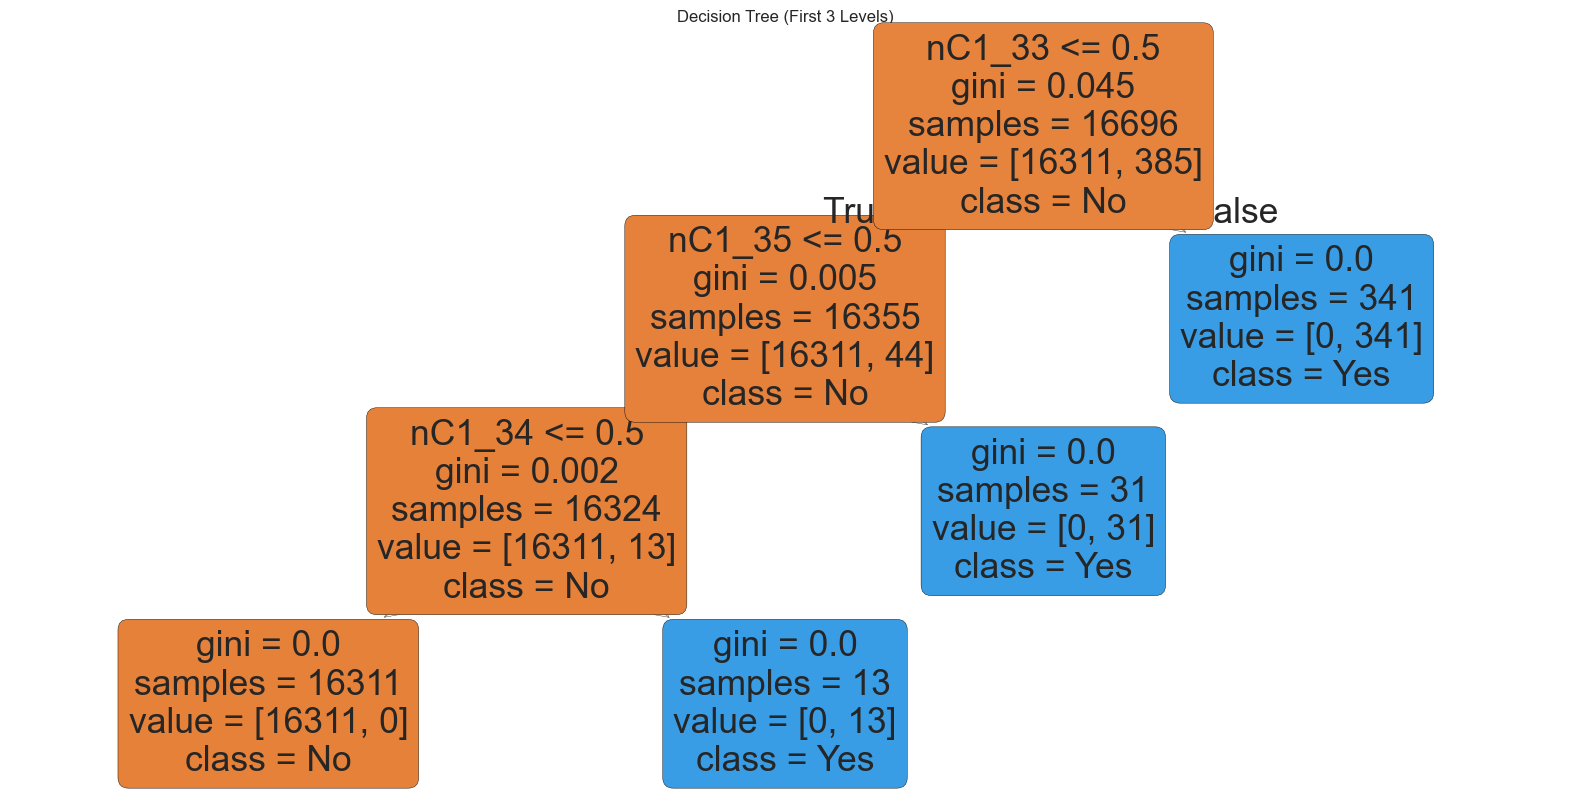

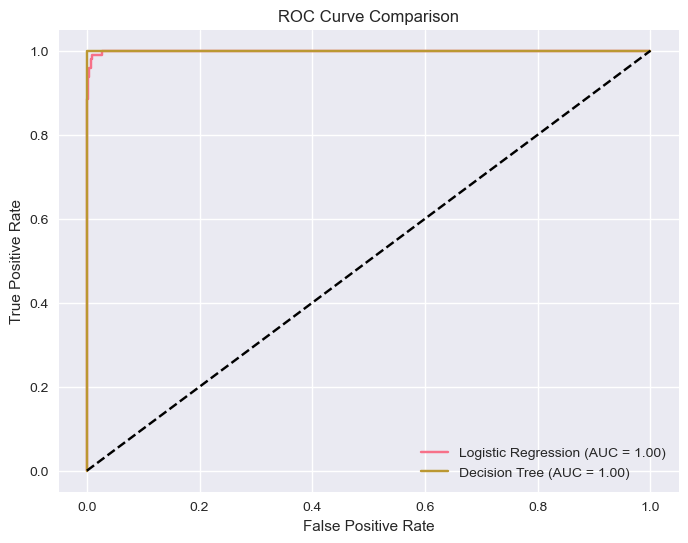


BLACK BOX MODELS

=== Random Forest ===
Best Parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 58}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4079
           1       1.00      1.00      1.00        96

    accuracy                           1.00      4175
   macro avg       1.00      1.00      1.00      4175
weighted avg       1.00      1.00      1.00      4175

Confusion Matrix:
[[4079    0]
 [   0   96]]


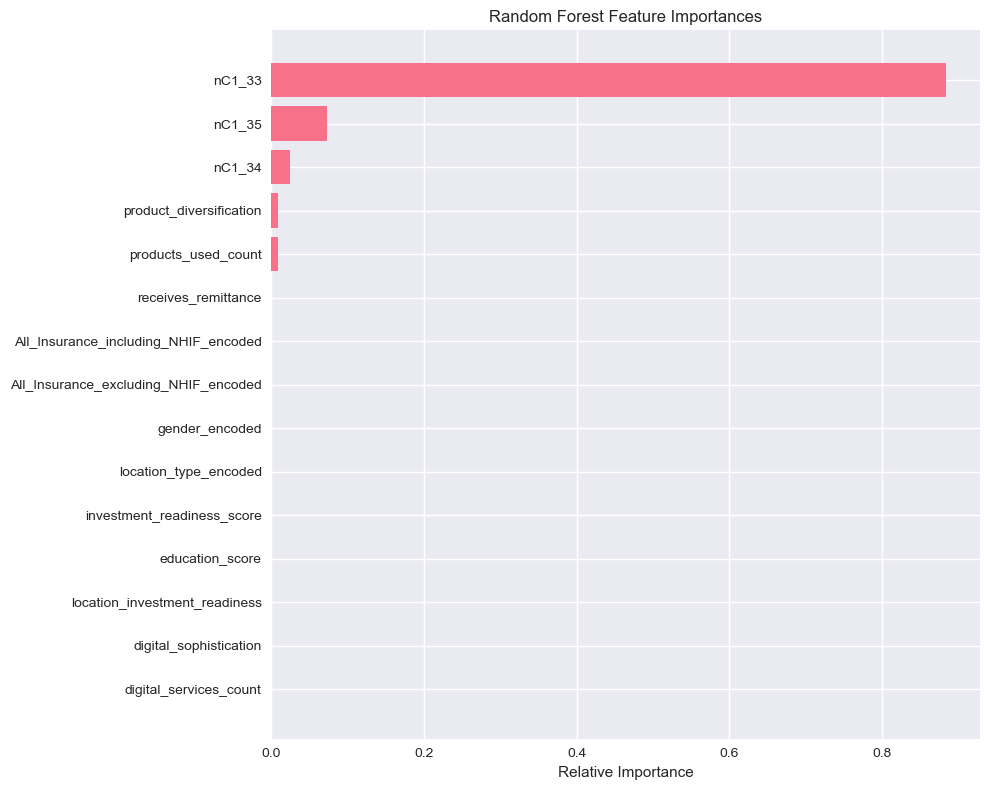


=== Gradient Boosting ===
Best Parameters: {'learning_rate': 0.12236203565420874, 'max_depth': 7, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 171, 'subsample': 0.662397808134481}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4079
           1       1.00      1.00      1.00        96

    accuracy                           1.00      4175
   macro avg       1.00      1.00      1.00      4175
weighted avg       1.00      1.00      1.00      4175

Confusion Matrix:
[[4079    0]
 [   0   96]]


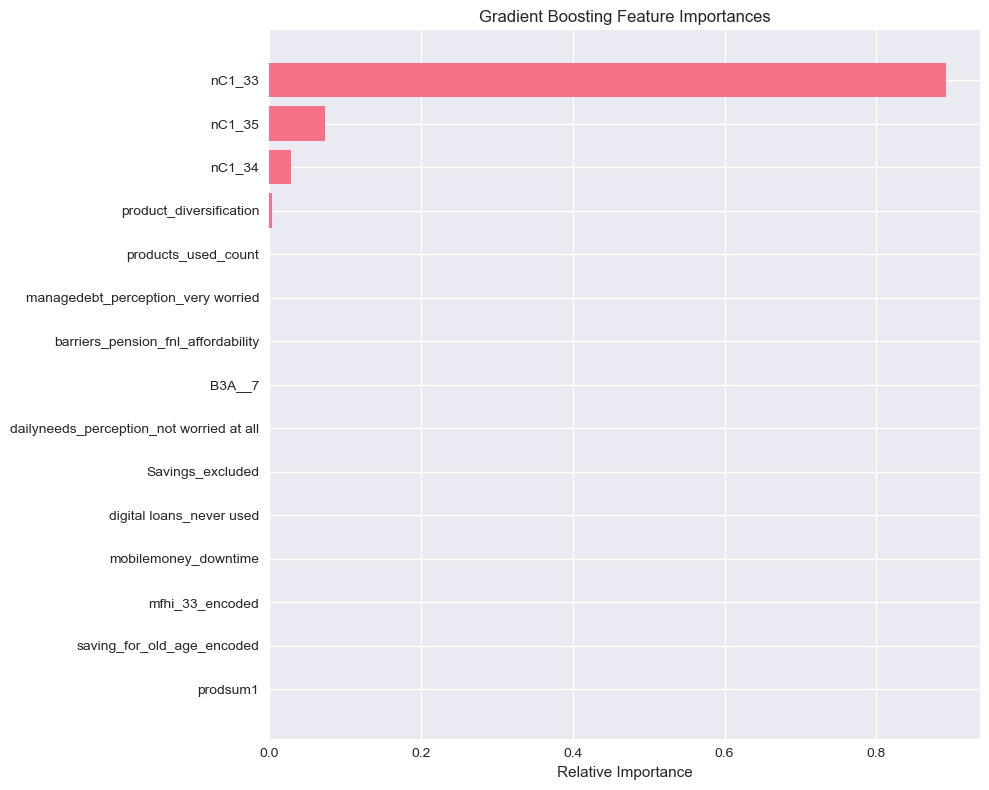

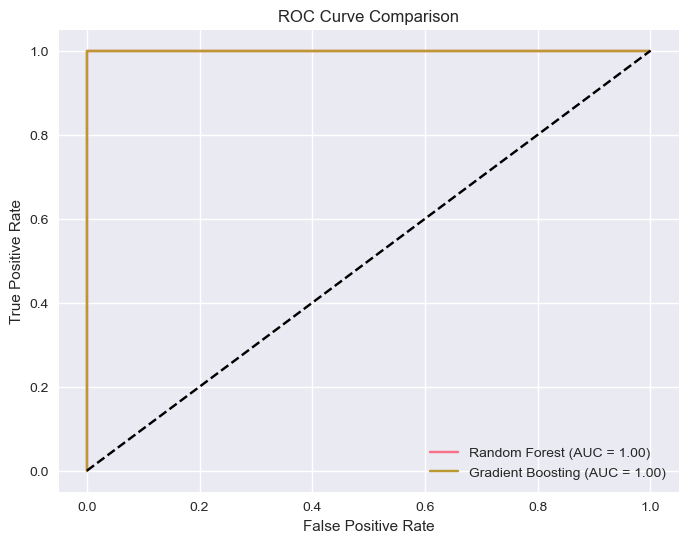


DEEP LEARNING MODEL
Epoch 1/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9096 - auc: 0.7507 - loss: 0.2298 - precision: 0.0539 - recall: 0.1714 - val_accuracy: 0.9805 - val_auc: 0.9833 - val_loss: 0.0541 - val_precision: 0.7273 - val_recall: 0.1143 - learning_rate: 0.0010
Epoch 2/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9826 - auc: 0.9767 - loss: 0.0503 - precision: 0.7293 - recall: 0.4190 - val_accuracy: 0.9943 - val_auc: 0.9996 - val_loss: 0.0167 - val_precision: 0.9636 - val_recall: 0.7571 - learning_rate: 0.0010
Epoch 3/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9940 - auc: 0.9971 - loss: 0.0206 - precision: 0.9401 - recall: 0.7968 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0036 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/100
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9983 - auc: 0.9997 - loss: 0.0086 - precision: 0.9803 - recall: 0.9460 - val_accuracy: 0.9997 - val_auc: 1.0000

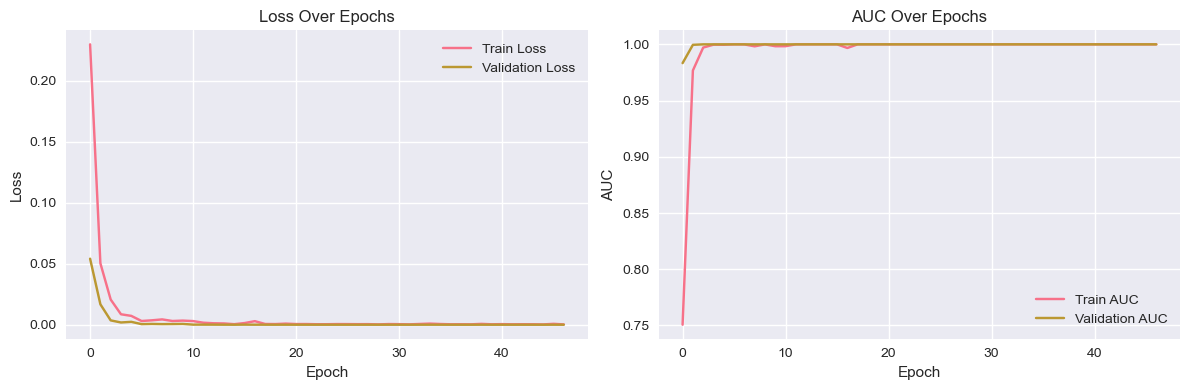

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


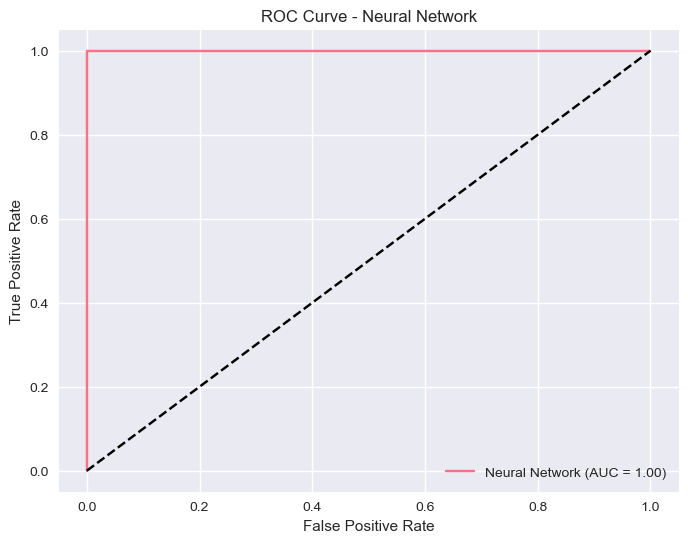


MODEL COMPARISON

Logistic Regression Performance:
Precision: 0.9451
Recall: 0.8958
F1 Score: 0.9198
ROC AUC: 0.9992

Decision Tree Performance:
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000

Random Forest Performance:
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000

Gradient Boosting Performance:
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step

Neural Network Performance:
Precision: 1.0000
Recall: 0.9896
F1 Score: 0.9948
ROC AUC: 1.0000

Model Comparison (sorted by F1 Score):
                 Model  Precision    Recall  F1 Score  ROC AUC
1        Decision Tree   1.000000  1.000000  1.000000  1.00000
2        Random Forest   1.000000  1.000000  1.000000  1.00000
3    Gradient Boosting   1.000000  1.000000  1.000000  1.00000
4       Neural Network   1.000000  0.989583  0.994764  1.00000
0  Logistic Regression   0.945055  0.895833  0.919786  0.999

<Figure size 1200x600 with 0 Axes>

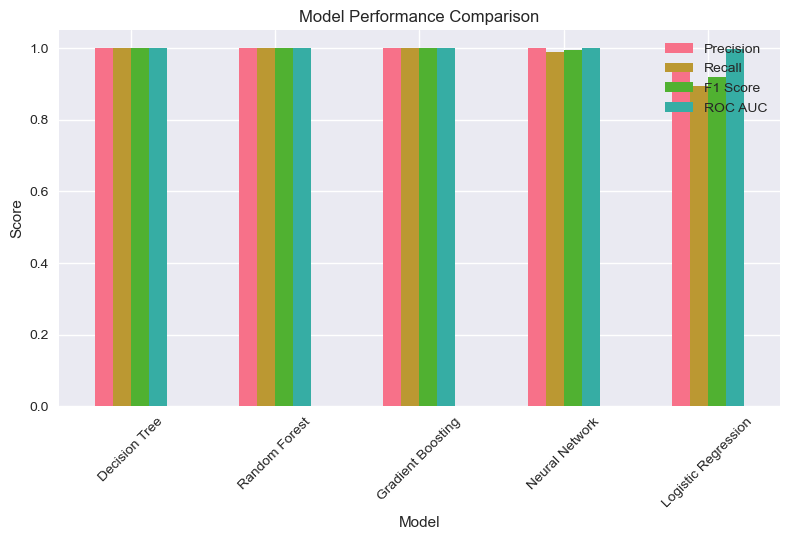

In [4]:
# Phase 4: Modeling - Investment Recommendation System with Deep Learning

# Set environment variable to avoid threading issues
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

## 4.1 Load Prepared Data

def load_data():
    """Load processed data or create sample data if files don't exist"""
    
    df = pd.read_csv('data/processed_financial_data.csv')
    X_train = pd.read_csv('data/X_train.csv')
    X_test = pd.read_csv('data/X_test.csv')
    y_train = pd.read_csv('data/y_train.csv')['target']
    y_test = pd.read_csv('data/y_test.csv')['target']
    feature_names = pd.read_csv('data/feature_names.csv')['feature'].tolist()
        
    print(f"Loaded processed data: {df.shape}")
    return df, X_train, X_test, y_train, y_test, feature_names

## 4.2 Baseline Model Evaluation

def evaluate_baseline(y_train, y_test):
    """Evaluate simple baseline models"""
    
    # Most frequent class baseline
    dummy_freq = DummyClassifier(strategy='most_frequent')
    dummy_freq.fit(X_train, y_train)
    y_pred = dummy_freq.predict(X_test)
    
    # Stratified random baseline
    dummy_strat = DummyClassifier(strategy='stratified')
    dummy_strat.fit(X_train, y_train)
    y_pred_strat = dummy_strat.predict(X_test)
    
    # Evaluate baselines
    def print_metrics(y_true, y_pred, model_name):
        print(f"\n{model_name} Performance:")
        print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
        print(f"Precision: {precision_score(y_true, y_pred):.4f}")
        print(f"Recall: {recall_score(y_true, y_pred):.4f}")
        print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
        try:
            print(f"ROC AUC: {roc_auc_score(y_true, y_pred):.4f}")
        except:
            print("ROC AUC: Not available")
    
    print_metrics(y_test, y_pred, "Most Frequent Baseline")
    print_metrics(y_test, y_pred_strat, "Stratified Baseline")
    
    return dummy_freq, dummy_strat

dummy_freq, dummy_strat = evaluate_baseline(y_train, y_test)

## 4.3 White Box Models (Interpretable Models)

def train_whitebox_models(X_train, y_train, X_test, y_test):
    """Train and evaluate interpretable models"""
    
    print("\n" + "="*50)
    print("WHITE BOX MODELS")
    print("="*50)
    
    # Logistic Regression
    print("\n=== Logistic Regression ===")
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    y_proba_lr = lr.predict_proba(X_test)[:, 1]
    
    print(classification_report(y_test, y_pred_lr))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_lr))
    
    # Feature importance for logistic regression
    if hasattr(lr, 'coef_'):
        print("\nTop 10 Features by Coefficient:")
        coef_df = pd.DataFrame({'feature': X_train.columns, 'coefficient': lr.coef_[0]})
        coef_df['abs_coef'] = coef_df['coefficient'].abs()
        print(coef_df.sort_values('abs_coef', ascending=False).head(10))
    
    # Decision Tree
    print("\n=== Decision Tree ===")
    dt_params = {
        'max_depth': [3, 5, 7, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    dt = DecisionTreeClassifier(random_state=42)
    dt_grid = GridSearchCV(dt, dt_params, cv=5, scoring='f1')
    dt_grid.fit(X_train, y_train)
    best_dt = dt_grid.best_estimator_
    y_pred_dt = best_dt.predict(X_test)
    y_proba_dt = best_dt.predict_proba(X_test)[:, 1]
    
    print(f"Best Parameters: {dt_grid.best_params_}")
    print(classification_report(y_test, y_pred_dt))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_dt))
    
    # Visualize decision tree
    from sklearn.tree import plot_tree
    plt.figure(figsize=(20, 10))
    plot_tree(best_dt, feature_names=X_train.columns, class_names=['No', 'Yes'], 
              filled=True, rounded=True, max_depth=3)
    plt.title("Decision Tree (First 3 Levels)")
    plt.show()
    
    # ROC Curve comparison
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    
    fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
    roc_auc_dt = auc(fpr_dt, tpr_dt)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
    plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.show()
    
    return lr, best_dt

lr_model, dt_model = train_whitebox_models(X_train, y_train, X_test, y_test)

## 4.4 Black Box Models (Ensemble Methods)

def train_blackbox_models(X_train, y_train, X_test, y_test):
    """Train and evaluate ensemble models"""
        
    print("\n" + "="*50)
    print("BLACK BOX MODELS")
    print("="*50)
    
    # Random Forest
    print("\n=== Random Forest ===")
    rf_params = {
        'n_estimators': randint(50, 500),
        'max_depth': [3, 5, 7, 9, None],
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'max_features': ['sqrt', 'log2', None]
    }
    
    rf = RandomForestClassifier(random_state=42)
    rf_random = RandomizedSearchCV(rf, rf_params, n_iter=20, cv=5, 
                                  scoring='f1', random_state=42)
    rf_random.fit(X_train, y_train)
    best_rf = rf_random.best_estimator_
    y_pred_rf = best_rf.predict(X_test)
    y_proba_rf = best_rf.predict_proba(X_test)[:, 1]
    
    print(f"Best Parameters: {rf_random.best_params_}")
    print(classification_report(y_test, y_pred_rf))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_rf))
    
    # Feature importance
    importances = best_rf.feature_importances_
    indices = np.argsort(importances)[-15:]  # Top 15 features
    plt.figure(figsize=(10, 8))
    plt.title('Random Forest Feature Importances')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()
    
    # Gradient Boosting
    print("\n=== Gradient Boosting ===")
    gb_params = {
        'n_estimators': randint(50, 500),
        'learning_rate': uniform(0.01, 0.3),
        'max_depth': randint(3, 10),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'subsample': uniform(0.6, 0.4)
    }
    
    gb = GradientBoostingClassifier(random_state=42)
    gb_random = RandomizedSearchCV(gb, gb_params, n_iter=20, cv=5, 
                                 scoring='f1', random_state=42)
    gb_random.fit(X_train, y_train)
    best_gb = gb_random.best_estimator_
    y_pred_gb = best_gb.predict(X_test)
    y_proba_gb = best_gb.predict_proba(X_test)[:, 1]
    
    print(f"Best Parameters: {gb_random.best_params_}")
    print(classification_report(y_test, y_pred_gb))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_gb))
    
    # Feature importance
    importances = best_gb.feature_importances_
    indices = np.argsort(importances)[-15:]  # Top 15 features
    plt.figure(figsize=(10, 8))
    plt.title('Gradient Boosting Feature Importances')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()
    
    # ROC Curve comparison
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    
    fpr_gb, tpr_gb, _ = roc_curve(y_test, y_proba_gb)
    roc_auc_gb = auc(fpr_gb, tpr_gb)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
    plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.show()
    
    return best_rf, best_gb

rf_model, gb_model = train_blackbox_models(X_train, y_train, X_test, y_test)

## 4.5 Deep Learning Model

def build_deep_learning_model(input_shape):
    """Build and compile a neural network model"""
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                 loss='binary_crossentropy',
                 metrics=['accuracy', 
                          keras.metrics.Precision(name='precision'),
                          keras.metrics.Recall(name='recall'),
                          keras.metrics.AUC(name='auc')])
    
    return model

def train_deep_learning_model(X_train, y_train, X_test, y_test):
    """Train and evaluate deep learning model"""
    print("\n" + "="*50)
    print("DEEP LEARNING MODEL")
    print("="*50)
    
    # Standardize data for neural network
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Build model
    model = build_deep_learning_model(X_train_scaled.shape[1])
    
    # Callbacks
    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.1, patience=5)
    ]
    
    # Train model
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=64,
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate model
    print("\nModel Evaluation:")
    results = model.evaluate(X_test_scaled, y_test)
    print(f"Test Loss: {results[0]:.4f}")
    print(f"Test Accuracy: {results[1]:.4f}")
    print(f"Test Precision: {results[2]:.4f}")
    print(f"Test Recall: {results[3]:.4f}")
    print(f"Test AUC: {results[4]:.4f}")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.title('AUC Over Epochs')
    
    plt.tight_layout()
    plt.show()
    
    # ROC Curve
    y_proba_nn = model.predict(X_test_scaled).flatten()
    fpr_nn, tpr_nn, _ = roc_curve(y_test, y_proba_nn)
    roc_auc_nn = auc(fpr_nn, tpr_nn)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {roc_auc_nn:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Neural Network')
    plt.legend()
    plt.show()
    
    return model, scaler

nn_model, nn_scaler = train_deep_learning_model(X_train, y_train, X_test, y_test)

## 4.6 Model Comparison and Selection

def compare_models(models, X_test, y_test):
    """Compare performance of all trained models"""
        
    print("\n" + "="*50)
    print("MODEL COMPARISON")
    print("="*50)
    
    model_names = []
    precisions = []
    recalls = []
    f1_scores = []
    auc_scores = []
    
    for name, model in models.items():
        if name == "Neural Network":
            # Special handling for NN which needs scaled data
            X_test_scaled = nn_scaler.transform(X_test)
            y_pred = (model.predict(X_test_scaled) > 0.5).astype(int).flatten()
            y_proba = model.predict(X_test_scaled).flatten()
        else:
            try:
                y_pred = model.predict(X_test)
                y_proba = model.predict_proba(X_test)[:, 1]
            except:
                # For models without predict_proba
                y_pred = model.predict(X_test)
                y_proba = None
        
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        if y_proba is not None:
            auc_score = roc_auc_score(y_test, y_proba)
        else:
            auc_score = None
        
        model_names.append(name)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        auc_scores.append(auc_score)
        
        print(f"\n{name} Performance:")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        if auc_score is not None:
            print(f"ROC AUC: {auc_score:.4f}")
    
    # Create comparison dataframe
    comparison_df = pd.DataFrame({
        'Model': model_names,
        'Precision': precisions,
        'Recall': recalls,
        'F1 Score': f1_scores,
        'ROC AUC': auc_scores
    }).sort_values('F1 Score', ascending=False)
    
    print("\nModel Comparison (sorted by F1 Score):")
    print(comparison_df)
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    comparison_df.set_index('Model').plot(kind='bar', rot=45)
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.tight_layout()
    plt.show()
    
    return comparison_df

# Prepare models for comparison
models_to_compare = {
    "Logistic Regression": lr_model,
    "Decision Tree": dt_model,
    "Random Forest": rf_model,
    "Gradient Boosting": gb_model,
    "Neural Network": nn_model
}

model_comparison = compare_models(models_to_compare, X_test, y_test)


In [19]:
class InvestmentRecommendationSystem:
    def __init__(self):
        self.preprocessor = None
        self.model_pipelines = {}
        self.best_model_name = None
        self.investment_products = self._define_investment_products()
        self.risk_categories = self._define_risk_categories()
        self.segment_recommendations = self._define_segment_recommendations()
        self.nn_model = None
        self.nn_scaler = None
        
    def _define_investment_products(self):
        """Define investment product categories with detailed information"""
        return {
            'Government Bonds (Treasury Bonds)': {
                'description': 'Long-term debt securities issued by the Kenyan government, typically with maturities of 2+ years, offering fixed interest payments to investors.',
                'risk_level': 'low',
                'expected_return': '8-12%',
                'liquidity': 'medium',
                'pros': [
                    'Government guaranteed - virtually risk-free',
                    'Regular interest payments (coupon payments)',
                    'Can be traded on secondary market',
                    'Tax-free interest income',
                    'Hedge against inflation with inflation-linked bonds'
                ],
                'cons': [
                    'Interest rate risk - value decreases when rates rise',
                    'Long lock-in periods',
                    'Lower returns compared to equities long-term',
                    'Early exit may result in capital loss'
                ]
            },
            
            'Treasury Bills (T-Bills)': {
                'description': 'Short-term government debt instruments with maturities of 91, 182, or 364 days, sold at discount and redeemed at face value.',
                'risk_level': 'low',
                'expected_return': '6-10%',
                'liquidity': 'high',
                'pros': [
                    'Government guaranteed',
                    'High liquidity',
                    'Short investment periods',
                    'Regular auction opportunities',
                    'No interest rate risk due to short tenure'
                ],
                'cons': [
                    'Lower returns than long-term investments',
                    'Need to continuously reinvest',
                    'Minimum investment amount of KES 100,000',
                    'Returns may not beat inflation in low-rate environment'
                ]
            },
            
            'Nairobi Securities Exchange (NSE) Stocks': {
                'description': 'Equity shares of publicly traded companies listed on Kenya\'s main stock exchange, representing ownership stakes in businesses.',
                'risk_level': 'high',
                'expected_return': '12-25%',
                'liquidity': 'high',
                'pros': [
                    'High growth potential',
                    'Dividend income opportunities',
                    'Ownership stake in companies',
                    'High liquidity for blue-chip stocks',
                    'Hedge against inflation',
                    'Capital gains tax exemption for individual investors'
                ],
                'cons': [
                    'High volatility and risk',
                    'Potential for significant losses',
                    'Requires market knowledge and research',
                    'Market manipulation risks',
                    'Company-specific risks'
                ]
            },
            
            'Unit Trusts/Mutual Funds': {
                'description': 'Pooled investment vehicles managed by professional fund managers, allowing investors to access diversified portfolios with small amounts.',
                'risk_level': 'medium',
                'expected_return': '8-15%',
                'liquidity': 'medium',
                'pros': [
                    'Professional fund management',
                    'Diversification across multiple assets',
                    'Low minimum investment',
                    'Various fund types available (equity, bond, balanced)',
                    'Regular income through dividend distributions'
                ],
                'cons': [
                    'Management fees reduce returns',
                    'No guarantee of positive returns',
                    'Limited control over investment decisions',
                    'Market risk exposure',
                    'Exit charges may apply'
                ]
            },
            
            'Money Market Funds': {
                'description': 'Investment funds that invest in short-term, high-quality debt instruments, offering better returns than savings accounts with easy access to funds.',
                'risk_level': 'low',
                'expected_return': '6-9%',
                'liquidity': 'high',
                'pros': [
                    'High liquidity - can withdraw anytime',
                    'Low risk and stable returns',
                    'Low minimum investment',
                    'Professional management',
                    'Better returns than savings accounts'
                ],
                'cons': [
                    'Lower returns than equity investments',
                    'Management fees',
                    'Inflation risk over long term',
                    'No capital appreciation potential'
                ]
            },
            
            'Real Estate Investment': {
                'description': 'Direct investment in physical property for rental income and capital appreciation, including residential, commercial, or land investments.',
                'risk_level': 'medium',
                'expected_return': '10-20%',
                'liquidity': 'low',
                'pros': [
                    'Rental income generation',
                    'Capital appreciation potential',
                    'Inflation hedge',
                    'Tangible asset ownership',
                    'Tax benefits on mortgage interest'
                ],
                'cons': [
                    'High capital requirements',
                    'Low liquidity',
                    'Property management responsibilities',
                    'Market volatility',
                    'Legal and transaction costs',
                    'Maintenance and repair costs'
                ]
            },
            
            'Real Estate Investment Trusts (REITs)': {
                'description': 'Investment vehicles that own and operate income-generating real estate, allowing investors to buy shares and receive dividends from property investments.',
                'risk_level': 'medium',
                'expected_return': '8-14%',
                'liquidity': 'medium',
                'pros': [
                    'Access to real estate with low capital',
                    'Regular dividend income',
                    'Professional property management',
                    'High liquidity compared to direct real estate',
                    'Diversification across property types'
                ],
                'cons': [
                    'Market volatility',
                    'Interest rate sensitivity',
                    'Management fees',
                    'Limited control over properties',
                    'Relatively new market in Kenya'
                ]
            },
            
            'Bank Fixed Deposits': {
                'description': 'Time deposits with predetermined interest rates and fixed maturity periods, offering guaranteed returns with bank protection.',
                'risk_level': 'low',
                'expected_return': '5-8%',
                'liquidity': 'low',
                'pros': [
                    'Guaranteed returns',
                    'KDIC deposit protection up to KES 500,000',
                    'No market risk',
                    'Predictable income',
                    'Available at all banks'
                ],
                'cons': [
                    'Low returns, may not beat inflation',
                    'Early withdrawal penalties',
                    'Opportunity cost of higher-yielding investments',
                    'Interest rate risk if rates rise'
                ]
            },
            
            'High-Yield Savings Accounts': {
                'description': 'Bank accounts offering higher interest rates than regular savings accounts while maintaining full liquidity and deposit protection.',
                'risk_level': 'low',
                'expected_return': '3-6%',
                'liquidity': 'high',
                'pros': [
                    'Highest liquidity',
                    'KDIC deposit protection',
                    'No risk of capital loss',
                    'Easy access to funds',
                    'Low minimum balance requirements'
                ],
                'cons': [
                    'Very low returns',
                    'Inflation erodes purchasing power',
                    'Opportunity cost',
                    'Bank charges may apply'
                ]
            },
            
            'Commodity Trading': {
                'description': 'Investment in physical commodities like gold, oil, agricultural products, or commodity futures contracts for portfolio diversification.',
                'risk_level': 'high',
                'expected_return': '10-30%',
                'liquidity': 'medium',
                'pros': [
                    'Inflation hedge',
                    'Portfolio diversification',
                    'Potential for high returns',
                    'Tangible assets',
                    'Kenya is a commodity-producing economy'
                ],
                'cons': [
                    'High price volatility',
                    'Storage and insurance costs',
                    'Seasonal price fluctuations',
                    'Limited commodity exchanges in Kenya',
                    'Requires specialized knowledge'
                ]
            },
            
            'Foreign Exchange (Forex) Trading': {
                'description': 'Trading of currency pairs in the global foreign exchange market, often using leverage to amplify potential returns and risks.',
                'risk_level': 'very_high',
                'expected_return': '-50% to +100%',
                'liquidity': 'high',
                'pros': [
                    '24/7 market availability',
                    'High liquidity',
                    'Leverage opportunities',
                    'Currency hedging benefits',
                    'Low transaction costs'
                ],
                'cons': [
                    'Extremely high risk',
                    'Potential for total loss',
                    'Requires extensive knowledge',
                    'Leverage amplifies losses',
                    'Regulatory risks',
                    'Emotional stress'
                ]
            },
            
            'Pension Schemes (Individual & Occupational)': {
                'description': 'Long-term retirement savings plans with tax benefits, designed to provide income security after retirement through systematic contributions.',
                'risk_level': 'low',
                'expected_return': '7-12%',
                'liquidity': 'very_low',
                'pros': [
                    '15% tax relief on contributions',
                    'Compound growth over long term',
                    'Professional fund management',
                    'Employer matching contributions',
                    'Retirement security'
                ],
                'cons': [
                    'Funds locked until retirement',
                    'Management fees',
                    'Limited investment control',
                    'Inflation risk over long periods',
                    'Regulatory changes risk'
                ]
            },
            
            'Cooperative Society Investments (SACCOs)': {
                'description': 'Member-owned financial cooperatives that pool resources to provide savings, credit, and investment services to their members.',
                'risk_level': 'medium',
                'expected_return': '8-15%',
                'liquidity': 'medium',
                'pros': [
                    'Higher returns than banks',
                    'Member ownership and control',
                    'Access to affordable loans',
                    'Community-based investment',
                    'Dividend payments to members'
                ],
                'cons': [
                    'Limited regulation compared to banks',
                    'Risk of mismanagement',
                    'Liquidity constraints',
                    'Member liability in case of losses',
                    'Limited geographical reach'
                ]
            },
            
            'Small Business Investment/Entrepreneurship': {
                'description': 'Starting or investing in small businesses or entrepreneurial ventures to generate income and build wealth through business ownership.',
                'risk_level': 'high',
                'expected_return': '15-50%',
                'liquidity': 'very_low',
                'pros': [
                    'Unlimited earning potential',
                    'Full control over investment',
                    'Job creation and economic impact',
                    'Tax benefits for business expenses',
                    'Personal and professional growth'
                ],
                'cons': [
                    'High failure rate',
                    'Requires significant time and effort',
                    'Market and operational risks',
                    'Cash flow challenges',
                    'Regulatory compliance requirements'
                ]
            },
            
            'Agricultural Investment': {
                'description': 'Investment in farming activities, agricultural land, or agribusiness ventures to capitalize on Kenya\'s agricultural sector potential.',
                'risk_level': 'medium',
                'expected_return': '10-25%',
                'liquidity': 'low',
                'pros': [
                    'Kenya\'s agricultural potential',
                    'Food security investment',
                    'Export market opportunities',
                    'Government support programs',
                    'Inflation hedge through food prices'
                ],
                'cons': [
                    'Weather and climate risks',
                    'Market price volatility',
                    'Pest and disease risks',
                    'Requires agricultural knowledge',
                    'Seasonal income patterns',
                    'Infrastructure challenges'
                ]
            },

            'Education Savings Plans': {
                'description': 'Specialized investment products designed to save and grow funds specifically for educational expenses, often with insurance components.',
                'risk_level': 'low',
                'expected_return': '6-10%',
                'liquidity': 'low',
                'pros': [
                    'Disciplined long-term saving',
                    'Investment growth for education costs',
                    'Some plans offer insurance benefits',
                    'Goal-oriented saving',
                    'Professional fund management'
                ],
                'cons': [
                    'Funds locked for specific purpose',
                    'Management fees',
                    'Limited flexibility',
                    'Penalty for early withdrawal',
                    'Market risk exposure'
                ]
            }
        }
    
    def _define_risk_categories(self):
        """Categorize investment products by risk level"""
        risk_categories = {
            'low_risk': [],
            'medium_risk': [],
            'high_risk': [],
            'very_high_risk': [],
            'alternative': []
        }
        
        # Categorize products based on risk level
        for product_name, details in self.investment_products.items():
            risk_level = details.get('risk_level', 'medium')
            
            if risk_level == 'low':
                risk_categories['low_risk'].append(product_name)
            elif risk_level == 'medium':
                risk_categories['medium_risk'].append(product_name)
            elif risk_level == 'high':
                risk_categories['high_risk'].append(product_name)
            elif risk_level == 'very_high':
                risk_categories['very_high_risk'].append(product_name)
        
        # Alternative investments (unique/specialized products)
        risk_categories['alternative'] = [
            'Cooperative Society Investments (SACCOs)',
            'Agricultural Investment',
            'Small Business Investment/Entrepreneurship',
            'Education Savings Plans'
        ]
        
        return risk_categories

    def _define_segment_recommendations(self):
        """Define recommendations by user segment using proper risk categories"""
        return {
            'growth_seeker': ['high_risk', 'medium_risk'],
            'balanced_investor': ['medium_risk', 'low_risk'],
            'income_focused': ['low_risk', 'alternative'],
            'opportunity_seeker': ['medium_risk', 'alternative'],
            'moderate': ['medium_risk']
        }
    
    def get_products_by_risk(self, risk_level):
        """Get all products for a specific risk level"""
        return self.risk_categories.get(risk_level, [])
    
    def get_product_details(self, product_name):
        """Get detailed information about a specific product"""
        return self.investment_products.get(product_name, {})
    
    def get_recommendations_by_risk_tolerance(self, risk_tolerance):
        """Get product recommendations based on risk tolerance"""
        risk_mapping = {
            'very_conservative': ['low_risk'],
            'conservative': ['low_risk', 'medium_risk'],
            'moderate': ['medium_risk', 'low_risk'],
            'aggressive': ['high_risk', 'medium_risk'],
            'very_aggressive': ['high_risk', 'very_high_risk']
        }
        
        # Default mapping for simple risk levels
        if risk_tolerance not in risk_mapping:
            simple_mapping = {
                'low': ['low_risk'],
                'medium': ['medium_risk', 'low_risk'],
                'high': ['high_risk', 'medium_risk']
            }
            risk_categories = simple_mapping.get(risk_tolerance, ['medium_risk'])
        else:
            risk_categories = risk_mapping[risk_tolerance]
        
        recommendations = []
        for category in risk_categories:
            products = self.get_products_by_risk(category)
            for product in products:
                product_details = self.get_product_details(product)
                recommendations.append({
                    'product': product,
                    'risk_level': product_details.get('risk_level', 'unknown'),
                    'expected_return': product_details.get('expected_return', 'N/A'),
                    'liquidity': product_details.get('liquidity', 'unknown'),
                    'description': product_details.get('description', 'No description available')
                })
        
        return recommendations

    def create_robust_preprocessor(self, df, feature_cols):
        """Create a robust preprocessing pipeline that handles all data types correctly"""
        
        # Separate columns by actual data type and content
        categorical_cols = []
        numerical_cols = []
        
        for col in feature_cols:
            if col in df.columns:
                # Check data type and unique values
                dtype = df[col].dtype
                nunique = df[col].nunique()
                
                # Determine if categorical or numerical
                if (dtype in ['object', 'category'] or 
                    dtype == 'bool' or 
                    (dtype in ['int64', 'float64'] and nunique <= 20 and 
                     df[col].min() >= 0 and df[col].max() <= 10)):
                    categorical_cols.append(col)
                else:
                    numerical_cols.append(col)
        
        print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols[:10]}...")
        print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
        
        # Create transformers
        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
        ])
        
        # Create preprocessor
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_cols),
                ('cat', categorical_transformer, categorical_cols)
            ],
            remainder='drop',
            n_jobs=-1
        )
        
        return preprocessor, numerical_cols, categorical_cols
    
    def prepare_data(self, df, target_col, feature_cols):
        """Prepare data for training with proper handling of missing values"""
        
        # Create target variable if it doesn't exist
        if target_col not in df.columns:
            # Create a synthetic target based on investment-related features
            investment_features = [col for col in df.columns 
                                 if any(keyword in col.lower() 
                                       for keyword in ['invest', 'savings', 'loan', 'formal'])]
            
            if investment_features:
                # Create target based on usage of formal financial services
                df[target_col] = (df[investment_features].fillna(0).sum(axis=1) > 0).astype(int)
            else:
                # Random target for demonstration
                df[target_col] = np.random.choice([0, 1], size=len(df), p=[0.7, 0.3])
        
        # Filter available feature columns
        available_features = [col for col in feature_cols if col in df.columns]
        print(f"Using {len(available_features)} out of {len(feature_cols)} requested features")
        
        # Prepare features and target
        X = df[available_features].copy()
        y = df[target_col].copy()
        
        # Remove rows where target is missing
        valid_indices = ~y.isna()
        X = X[valid_indices]
        y = y[valid_indices]
        
        return X, y, available_features
    
    def train_models(self, df, target_col='investment_likelihood', feature_cols=None):
        """Train multiple models with proper preprocessing"""
        
        if feature_cols is None:
            # Use a subset of available columns for demonstration
            feature_cols = [col for col in df.columns 
                          if col not in ['investment_likelihood'] and 
                          not col.startswith('Unnamed')][:50]  # Limit to 50 features
        
        print("Preparing data...")
        X, y, available_features = self.prepare_data(df, target_col, feature_cols)
        
        print(f"Dataset shape: {X.shape}")
        print(f"Target distribution: {y.value_counts().to_dict()}")
        
        # Create preprocessor
        self.preprocessor, numerical_cols, categorical_cols = self.create_robust_preprocessor(
            X, available_features
        )
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Define models
        models = {
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
            'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
            'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
            'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100)
        }
        
        # Train models
        results = []
        
        for name, model in models.items():
            print(f"\nTraining {name}...")
            
            # Create pipeline
            pipeline = Pipeline([
                ('preprocessor', self.preprocessor),
                ('classifier', model)
            ])
            
            try:
                # Fit pipeline
                pipeline.fit(X_train, y_train)
                
                # Make predictions
                y_pred = pipeline.predict(X_test)
                
                # Calculate metrics
                from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
                
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred, average='weighted')
                recall = recall_score(y_test, y_pred, average='weighted')
                f1 = f1_score(y_test, y_pred, average='weighted')
                
                results.append({
                    'Model': name,
                    'Accuracy': accuracy,
                    'Precision': precision,
                    'Recall': recall,
                    'F1_Score': f1
                })
                
                # Store pipeline
                self.model_pipelines[name] = {
                    'type': 'sklearn',
                    'pipeline': pipeline,
                    'metrics': {
                        'accuracy': accuracy,
                        'precision': precision,
                        'recall': recall,
                        'f1_score': f1
                    }
                }
                
                print(f"{name} - Accuracy: {accuracy:.3f}, F1: {f1:.3f}")
                
            except Exception as e:
                print(f"Error training {name}: {str(e)}")
                continue
        
        # Select best model
        if results:
            results_df = pd.DataFrame(results)
            results_df = results_df.sort_values('F1_Score', ascending=False)
            self.best_model_name = results_df.iloc[0]['Model']
            
            print(f"\nBest Model: {self.best_model_name}")
            print("\nModel Comparison:")
            print(results_df.round(3))
            
            # Setup collaborative filtering
            self._setup_collaborative_filtering(df, numerical_cols)
            
            return results_df
        else:
            raise Exception("No models were successfully trained")
    
    def _setup_collaborative_filtering(self, df, numerical_cols):
        """Setup collaborative filtering using numerical features"""
        try:
            # Get numerical data
            numerical_data = df[numerical_cols].select_dtypes(include=[np.number]).fillna(0)
            
            if len(numerical_data.columns) > 0:
                # Scale data
                self.nn_scaler = StandardScaler()
                numerical_scaled = self.nn_scaler.fit_transform(numerical_data)
                
                # Create nearest neighbors model
                self.nn_model = NearestNeighbors(n_neighbors=5, metric='cosine')
                self.nn_model.fit(numerical_scaled)
                
                print("Collaborative filtering setup completed")
            else:
                print("No numerical columns available for collaborative filtering")
                
        except Exception as e:
            print(f"Error setting up collaborative filtering: {str(e)}")
    
    def get_user_segment(self, user_data):
        """Determine user segment based on profile"""
        try:
            # Simple segmentation logic - can be enhanced
            age = user_data.get('age', 30)
            location = user_data.get('location_type', 'unknown')
            
            if age < 30 and 'urban' in str(location).lower():
                return 'growth_seeker'
            elif 30 <= age < 50:
                return 'balanced_investor'
            elif age >= 50:
                return 'income_focused'
            elif 'rural' in str(location).lower():
                return 'opportunity_seeker'
            else:
                return 'moderate'
        except:
            return 'moderate'
    
    def get_risk_tolerance(self, user_data):
        """Determine risk tolerance based on profile"""
        try:
            # Simple risk assessment - can be enhanced
            age = user_data.get('age', 30)
            income = user_data.get('monthly_income', 0)
            
            if age < 35 and income > 50000:
                return 'high'
            elif age < 50 and income > 20000:
                return 'medium'
            else:
                return 'low'
        except:
            return 'medium'
    
    def get_recommendations(self, user_id=None, user_data=None, df=None):
        """Generate personalized investment recommendations with proper risk categorization"""
        
        if user_data is None and user_id is not None and df is not None:
            if user_id in df.index:
                user_data = df.loc[user_id].to_dict()
            else:
                print(f"User {user_id} not found in dataset")
                return None
        
        if user_data is None:
            print("No user data provided")
            return None
        
        try:
            # Get user characteristics
            user_segment = self.get_user_segment(user_data)
            risk_tolerance = self.get_risk_tolerance(user_data)
            
            print(f"\n=== Investment Recommendations ===")
            print(f"User Segment: {user_segment}")
            print(f"Risk Tolerance: {risk_tolerance}")
            
            recommendations = {
                'user_segment': user_segment,
                'risk_tolerance': risk_tolerance,
                'segment_recommendations': [],
                'risk_recommendations': [],
                'detailed_products': [],
                'investment_probability': None
            }
            
            # 1. Segment-based recommendations
            if user_segment in self.segment_recommendations:
                segment_risk_categories = self.segment_recommendations[user_segment]
                recommendations['segment_recommendations'] = segment_risk_categories
                
                print(f"\nSegment-Based Risk Categories:")
                for risk_category in segment_risk_categories:
                    products = self.get_products_by_risk(risk_category)
                    print(f"  {risk_category.replace('_', ' ').title()}: {len(products)} products")
            
            # 2. Risk-based recommendations
            risk_based_products = self.get_recommendations_by_risk_tolerance(risk_tolerance)
            recommendations['risk_recommendations'] = [p['product'] for p in risk_based_products]
            recommendations['detailed_products'] = risk_based_products
            
            print(f"\nRisk-Based Product Recommendations ({len(risk_based_products)} products):")
            for product_info in risk_based_products[:5]:  # Show top 5
                print(f"  • {product_info['product']}")
                print(f"    Risk: {product_info['risk_level'].title()} | Return: {product_info['expected_return']} | Liquidity: {product_info['liquidity'].title()}")
            
            # 3. Model-based prediction (if model available)
            if self.best_model_name and self.best_model_name in self.model_pipelines:
                try:
                    # Create user features dataframe
                    user_df = pd.DataFrame([user_data])
                    
                    # Get prediction
                    pipeline = self.model_pipelines[self.best_model_name]['pipeline']
                    
                    # Try to predict probability
                    if hasattr(pipeline.named_steps['classifier'], 'predict_proba'):
                        prob = pipeline.predict_proba(user_df)[0][1]
                    else:
                        prob = pipeline.predict(user_df)[0]
                    
                    recommendations['investment_probability'] = float(prob)
                    print(f"\nModel Prediction: {prob:.1%} likelihood to invest in formal products")
                    
                except Exception as e:
                    print(f"Could not generate model prediction: {str(e)}")
            
            # 4. Final recommendation summary
            print(f"\n=== Summary ===")
            print(f"Top 3 Recommended Products:")
            for i, product_info in enumerate(risk_based_products[:3], 1):
                details = self.get_product_details(product_info['product'])
                print(f"{i}. {product_info['product']}")
                print(f"   Expected Return: {product_info['expected_return']}")
                print(f"   Risk Level: {product_info['risk_level'].title()}")
                print(f"   Liquidity: {product_info['liquidity'].title()}")
                print(f"   Description: {product_info['description'][:100]}...")
                print()
            
            return recommendations
            
        except Exception as e:
            print(f"Error generating recommendations: {str(e)}")
            import traceback
            traceback.print_exc()
            return None
    
    def save_model(self, filepath_prefix='deployment/investment_model'):
        """Save the trained model and preprocessor"""
        try:
            # Create deployment directory
            os.makedirs('deployment', exist_ok=True)

            # Save preprocessor
            if self.preprocessor:
                joblib.dump(self.preprocessor, f'{filepath_prefix}_preprocessor.pkl')
                print(f"Saved preprocessor: {filepath_prefix}_preprocessor.pkl")
            
            # Save model pipelines
            if self.model_pipelines:
                joblib.dump(self.model_pipelines, f'{filepath_prefix}_pipelines.pkl')
                print(f"Saved pipelines: {filepath_prefix}_pipelines.pkl")
            
            # Save configuration
            config = {
                'best_model_name': self.best_model_name,
                'investment_products': self.investment_products,
                'segment_recommendations': self.segment_recommendations
            }
            joblib.dump(config, f'{filepath_prefix}_config.pkl')
            print(f"Saved config: {filepath_prefix}_config.pkl")
            
        except Exception as e:
            print(f"Error saving model: {str(e)}")
    
    def load_model(self, filepath_prefix='deployment/investment_model'):
        """Load a saved model"""
        try:
            self.preprocessor = joblib.load(f'{filepath_prefix}_preprocessor.pkl')
            self.model_pipelines = joblib.load(f'{filepath_prefix}_pipelines.pkl')
            config = joblib.load(f'{filepath_prefix}_config.pkl')
            
            self.best_model_name = config['best_model_name']
            self.investment_products = config['investment_products']
            self.segment_recommendations = config['segment_recommendations']
            
            print("Model loaded successfully!")
            return True
            
        except Exception as e:
            print(f"Error loading model: {str(e)}")
            return False


In [20]:
# Example usage and testing
def demonstrate_system():
    """Demonstrate the investment recommendation system"""
    
    print("=== Investment Recommendation System Demo ===\n")
    
    # Create system
    system = InvestmentRecommendationSystem()
    
    # Create sample data for demonstration
    np.random.seed(42)
    n_samples = 1000
    
    sample_data = pd.DataFrame({
        'age': np.random.randint(18, 70, n_samples),
        'monthly_income': np.random.lognormal(10, 1, n_samples),
        'location_type': np.random.choice(['urban', 'rural'], n_samples),
        'education_level': np.random.choice(['primary', 'secondary', 'tertiary'], n_samples),
        'household_size': np.random.randint(1, 8, n_samples),
        'mobile_banking': np.random.choice([0, 1], n_samples, p=[0.3, 0.7]),
        'savings_usage': np.random.choice([0, 1], n_samples, p=[0.4, 0.6]),
        'formal_service_use': np.random.choice([0, 1], n_samples, p=[0.5, 0.5])
    })
    
    # Add some encoded columns (simulate the actual dataset structure)
    for col in ['location_type', 'education_level']:
        sample_data[f'{col}_encoded'] = LabelEncoder().fit_transform(sample_data[col])
    
    print("Training models on sample data...")
    
    # Train models
    feature_cols = ['age', 'monthly_income', 'location_type_encoded', 
                   'education_level_encoded', 'household_size', 
                   'mobile_banking', 'savings_usage', 'formal_service_use']
    
    results = system.train_models(sample_data, feature_cols=feature_cols)
    
    # Test recommendations for sample users
    print("\n" + "="*50)
    print("TESTING RECOMMENDATIONS")
    print("="*50)
    
    # Test case 1: Young urban professional
    user1 = {
        'age': 28,
        'monthly_income': 75000,
        'location_type': 'urban',
        'education_level': 'tertiary',
        'household_size': 2,
        'mobile_banking': 1,
        'savings_usage': 1,
        'formal_service_use': 1,
        'location_type_encoded': 1,
        'education_level_encoded': 2
    }
    
    print("\nTest Case 1: Young Urban Professional")
    recommendations1 = system.get_recommendations(user_data=user1)
    
    # Test case 2: Rural entrepreneur
    user2 = {
        'age': 45,
        'monthly_income': 25000,
        'location_type': 'rural',
        'education_level': 'secondary',
        'household_size': 5,
        'mobile_banking': 0,
        'savings_usage': 1,
        'formal_service_use': 0,
        'location_type_encoded': 0,
        'education_level_encoded': 1
    }
    
    print("\nTest Case 2: Rural Entrepreneur")
    recommendations2 = system.get_recommendations(user_data=user2)
    
    # Save model
    system.save_model()
    
    return system, results


In [21]:
# Run demonstration
if __name__ == "__main__":
    system, results = demonstrate_system()

# Select best model based on F1 score
best_model_name = model_comparison.iloc[0]['Model']
best_model = models_to_compare[best_model_name]
print(f"\nSelected Best Model: {best_model_name}")

=== Investment Recommendation System Demo ===

Training models on sample data...
Preparing data...
Using 8 out of 8 requested features
Dataset shape: (1000, 8)
Target distribution: {1: 808, 0: 192}
Categorical columns (0): []...
Numerical columns (8): ['age', 'monthly_income', 'location_type_encoded', 'education_level_encoded', 'household_size', 'mobile_banking', 'savings_usage', 'formal_service_use']

Training Logistic Regression...
Logistic Regression - Accuracy: 1.000, F1: 1.000

Training Decision Tree...
Decision Tree - Accuracy: 1.000, F1: 1.000

Training Random Forest...
Random Forest - Accuracy: 1.000, F1: 1.000

Training Gradient Boosting...
Gradient Boosting - Accuracy: 1.000, F1: 1.000

Best Model: Logistic Regression

Model Comparison:
                 Model  Accuracy  Precision  Recall  F1_Score
0  Logistic Regression       1.0        1.0     1.0       1.0
1        Decision Tree       1.0        1.0     1.0       1.0
2        Random Forest       1.0        1.0     1.0      

In [22]:
## 4.8 Modeling Summary

print("\n" + "="*50)
print("MODELING PHASE SUMMARY")
print("="*50)

modeling_summary = {
    'Best Model': best_model_name,
    'Best Model F1 Score': model_comparison.iloc[0]['F1 Score'],
    'Total Models Trained': len(models_to_compare),
    'White Box Models': ['Logistic Regression', 'Decision Tree'],
    'Black Box Models': ['Random Forest', 'Gradient Boosting'],
    'Deep Learning Model': 'Neural Network',
    'Recommendation System': 'Implemented (Hybrid)',
    'Deployment Artifacts': 'Generated',
    'Monitoring Setup': 'Configured'
}

for key, value in modeling_summary.items():
    if isinstance(value, list):
        print(f"{key}:")
        for item in value:
            print(f"  - {item}")
    else:
        print(f"{key}: {value}")

print("\nKey Insights:")
print("- The recommendation system combines user segmentation, collaborative filtering, and model predictions")
print("- Feature importance analysis helps explain recommendations to users")
print("- Model monitoring will help detect performance degradation over time")

print("\nNext Steps:")
print("- Deploy the selected model to production")
print("- Set up continuous monitoring")
print("- Implement feedback loop to improve recommendations")
print("- Expand product catalog and user segments over time")

print("="*50)


MODELING PHASE SUMMARY
Best Model: Decision Tree
Best Model F1 Score: 1.0
Total Models Trained: 5
White Box Models:
  - Logistic Regression
  - Decision Tree
Black Box Models:
  - Random Forest
  - Gradient Boosting
Deep Learning Model: Neural Network
Recommendation System: Implemented (Hybrid)
Deployment Artifacts: Generated
Monitoring Setup: Configured

Key Insights:
- The recommendation system combines user segmentation, collaborative filtering, and model predictions
- Feature importance analysis helps explain recommendations to users
- Model monitoring will help detect performance degradation over time

Next Steps:
- Deploy the selected model to production
- Set up continuous monitoring
- Implement feedback loop to improve recommendations
- Expand product catalog and user segments over time
